
# Tutorial: 10x multiome pbmc


The data consists of *PBMC from a Healthy Donor - Granulocytes Removed Through Cell Sorting (3k)* which is freely available from 10x Genomics (click [here](https://www.10xgenomics.com/resources/datasets/pbmc-from-a-healthy-donor-granulocytes-removed-through-cell-sorting-3-k-1-standard-2-0-0), some personal information needs to be provided before you can gain access to the data). This is a multi-ome dataset.

<div class="alert alert-info">

**Note:**

In this notebook we will only show the minimal steps needed for running the SCENIC+ analysis. For more information on analysing scRNA-seq data and scATAC-seq data we refer the reader to other tutorials (e.g. [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/index.html) and [pycisTopic](https://pycistopic.readthedocs.io/en/latest/) in python or [Seurat](https://satijalab.org/seurat/) and [cisTopic](https://github.com/aertslab/cisTopic) or [Signac](https://satijalab.org/signac/) in R).

</div>



## Set-up environment and download data 
We will first create a directory to store the data and results

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr                                                         
null = open(os.devnull,'wb')

In [2]:
!mkdir -p pbmc_tutorial/data
!wget -O pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5
!wget -O pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz

--2024-04-25 20:26:06--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 2606:4700::6812:ad, 2606:4700::6812:1ad, 104.18.1.173, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|2606:4700::6812:ad|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38844318 (37M) [binary/octet-stream]
Saving to: ‘pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5’

pbmc_tutorial/data/ 100%[===================>]  37.04M  20.2MB/s    in 1.8s    

2024-04-25 20:26:08 (20.2 MB/s) - ‘pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5’ saved [38844318/38844318]

--2024-04-25 20:26:08--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 2606:4700::6812:ad, 2606:4700::

In [3]:
import os
work_dir = 'pbmc_tutorial'

## scRNA-seq preprocessing using Scanpy
First we preprocess the scRNA-seq side of the mutliome datasets. Most importantly we will use this side of the data to annotate celltypes. 

For this we will make use of [Scanpy](https://scanpy.readthedocs.io/en/stable/). 


<div class="alert alert-info">

**Note:**

You may also use [Seurat](https://satijalab.org/seurat/) (or any other tool in fact) to preprocess your data, however this will require some extra steps to import the data in python.
</div>

<div class="alert alert-info">

**Note:**

Further on in the actual SCENIC+ analysis the raw count matrix will be used.
</div>


In [4]:
import scanpy as sc
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scRNA')):
    os.makedirs(os.path.join(work_dir, 'scRNA'))

Read in the scRNA-seq count matrix into [AnnData](https://anndata.readthedocs.io/en/latest/) object.

In [5]:
adata = sc.read_10x_h5(os.path.join(work_dir, 'data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5'))
adata.var_names_make_unique()
adata

/Users/tadeoye/miniconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2711 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [6]:
adata.obs

""
AAACAGCCAAATATCC-1
AAACAGCCAGGAACTG-1
AAACAGCCAGGCTTCG-1
AAACCAACACCTGCTC-1
AAACCAACAGATTCAT-1
...
TTTGTGGCATTAGCCA-1
TTTGTGGCATTGCGAC-1
TTTGTGTTCCGCCTAT-1
TTTGTGTTCCGTGACA-1


### Basic quality control

Only keep cells with at least 200 genes expressed and only keep genes which are expressed in at least 3 cells.

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

**Optionally**, predict and filter out doublets using [Scrublet](https://pubmed.ncbi.nlm.nih.gov/30954476/).

In [8]:
sc.external.pp.scrublet(adata) #estimates doublets

In [9]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 2626 × 21255
    obs: 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells'
    uns: 'scrublet'

Filter based on mitochondrial counts and total counts.

/var/folders/70/42xwxjh94x5f164djlw1hwpc0000gv/T/ipykernel_14388/3790233708.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


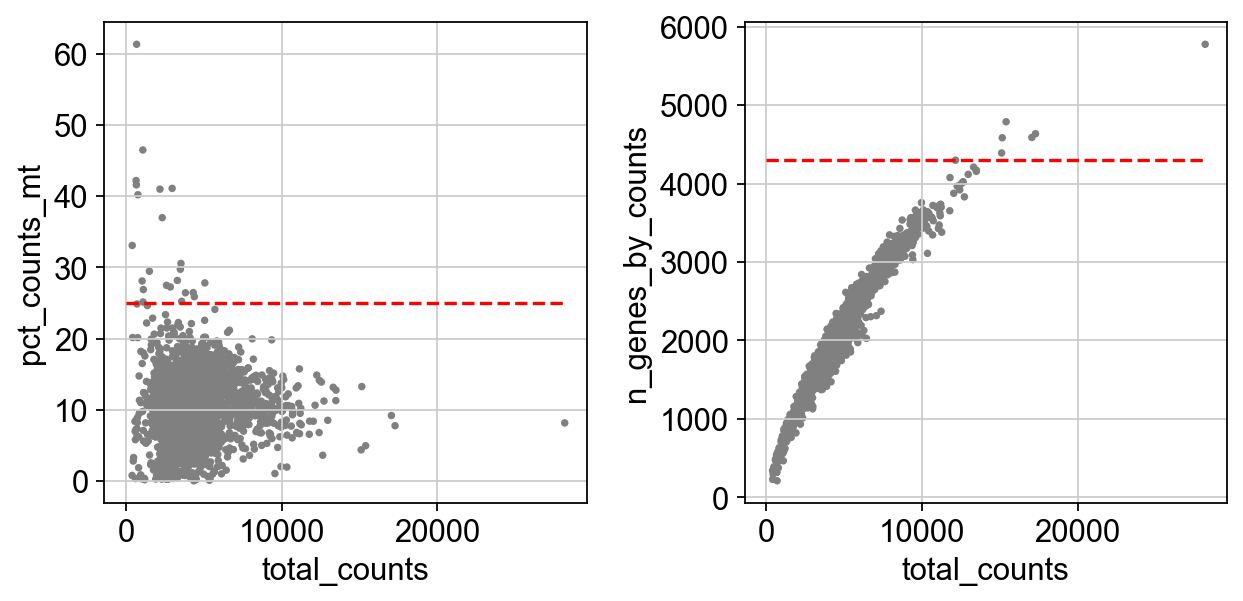

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
import matplotlib.pyplot as plt
mito_filter = 25
n_counts_filter = 4300
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)
#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

In [11]:
adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :]
adata = adata[adata.obs.pct_counts_mt < mito_filter, :]
adata

View of AnnData object with n_obs × n_vars = 2597 × 21255
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

### Data normalization

<div class="alert alert-info">

**Note:**

Below the data will be normalized and scaled. This is **only** for visualization purposes. For the actual SCENIC+ analysis we will use the raw count matrix. For this reason we save the non-normalized and non-scaled AnnData object in the raw slot before carying on.
</div>

In [12]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/Users/tadeoye/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:961: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Cell type annotation

Here we use a pre-annotated dataset as reference (this is actually the processed data from the main scanpy tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) to transfer labels to unannotated dataset using ingest. 

This is an important step of the preprocessing part because these annotations will be used in pycisTopic to generate pseudobulk ATAC profiles and call peaks.

In [13]:
adata_ref = sc.datasets.pbmc3k_processed() #use the preprocessed data from the Scanpy tutorial as reference
var_names = adata_ref.var_names.intersection(adata.var_names) #use genes which are present in both assays
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]
sc.pp.pca(adata_ref) #calculate PCA embedding
sc.pp.neighbors(adata_ref) #calculate neighborhood graph
sc.tl.umap(adata_ref) #calculate umap embedding
sc.tl.ingest(adata, adata_ref, obs='louvain') #run label transfer
adata.obs.rename({'louvain': 'ingest_celltype_label'}, inplace = True, axis = 1)

/Users/tadeoye/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/Users/tadeoye/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/tadeoye/miniconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Set

Let's visualize the labels

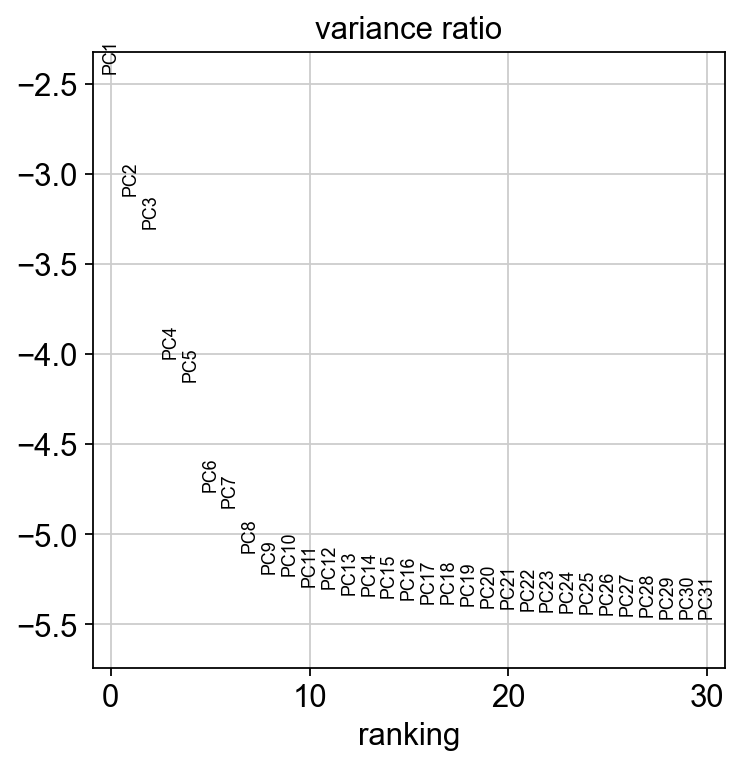

In [14]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

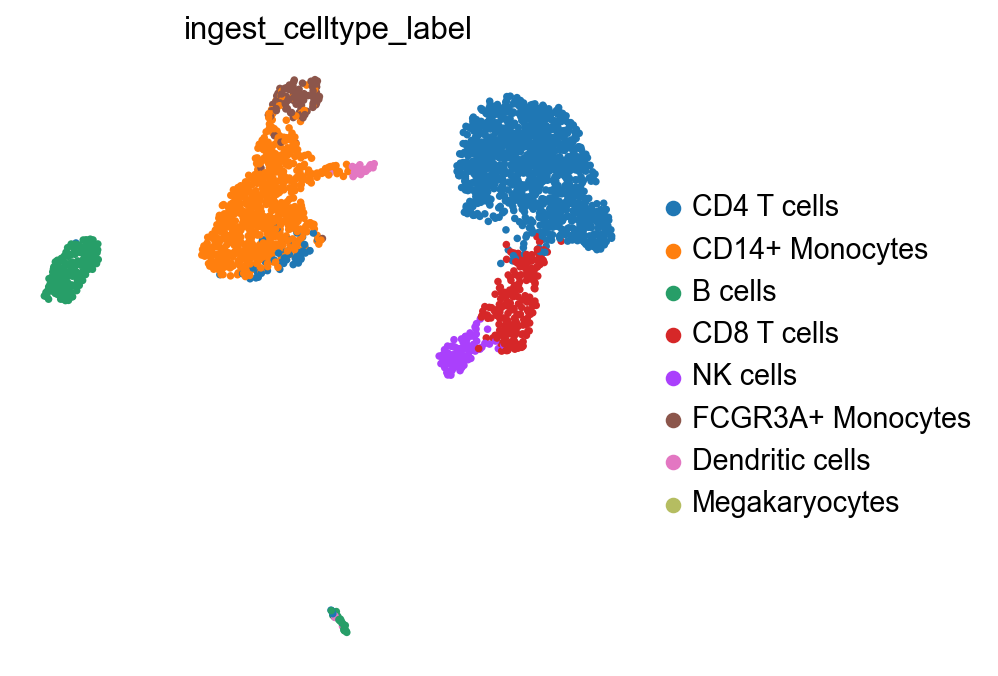

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'ingest_celltype_label')

We can clean the annotation a bit by running a clustering and assigning clusters to cell types based on maximum overlap.

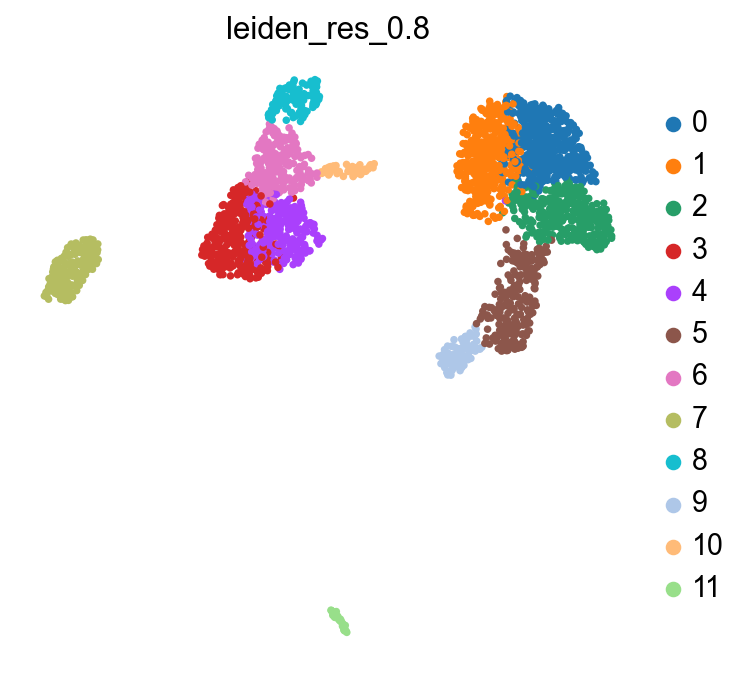

In [16]:
import scanpy as sc 

sc.tl.leiden(adata, resolution = 0.8, key_added = 'leiden_res_0.8')
sc.pl.umap(adata, color = 'leiden_res_0.8')

In [17]:
tmp_df = adata.obs.groupby(['leiden_res_0.8', 'ingest_celltype_label']).size().unstack(fill_value=0)
tmp_df = (tmp_df / tmp_df.sum(0)).fillna(0)
leiden_to_annotation = tmp_df.idxmax(1).to_dict()
leiden_to_annotation

{'0': 'CD4 T cells',
 '1': 'CD4 T cells',
 '2': 'CD4 T cells',
 '3': 'CD14+ Monocytes',
 '4': 'CD14+ Monocytes',
 '5': 'CD8 T cells',
 '6': 'CD14+ Monocytes',
 '7': 'B cells',
 '8': 'FCGR3A+ Monocytes',
 '9': 'NK cells',
 '10': 'Dendritic cells',
 '11': 'B cells'}

Note, there are two clusters annotated as B cells (cluster 7 and cluster 11). Let's call these cells B cells 1 and B cells 2.

Let's also remove the spaces from the cell type labels.

In [18]:
leiden_to_annotation['7'] = 'B cells 1'
leiden_to_annotation['11'] = 'B cells 2'
leiden_to_annotation = {cluster: leiden_to_annotation[cluster].replace(' ', '_') for cluster in leiden_to_annotation.keys()}
leiden_to_annotation

{'0': 'CD4_T_cells',
 '1': 'CD4_T_cells',
 '2': 'CD4_T_cells',
 '3': 'CD14+_Monocytes',
 '4': 'CD14+_Monocytes',
 '5': 'CD8_T_cells',
 '6': 'CD14+_Monocytes',
 '7': 'B_cells_1',
 '8': 'FCGR3A+_Monocytes',
 '9': 'NK_cells',
 '10': 'Dendritic_cells',
 '11': 'B_cells_2'}

Add the annotation to the AnnData object.

In [19]:
adata.obs['celltype'] = [leiden_to_annotation[cluster_id] for cluster_id in adata.obs['leiden_res_0.8']]
del(leiden_to_annotation)
del(tmp_df)

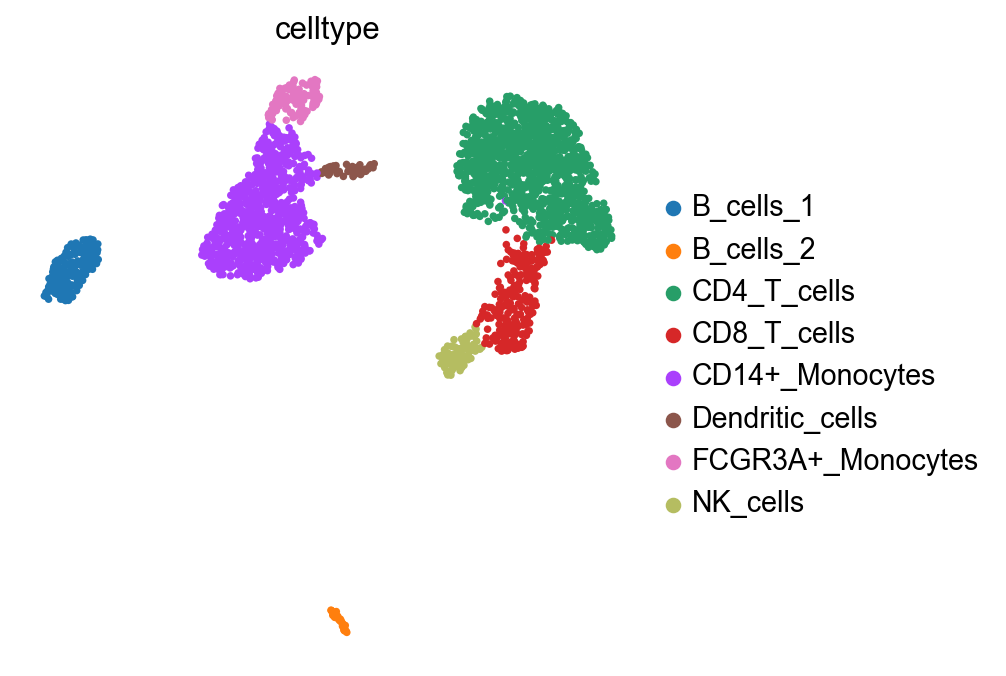

In [20]:
sc.pl.umap(adata, color = 'celltype')

### Save results

In [21]:
adata.write(os.path.join(work_dir, 'scRNA/adata.h5ad'), compression='gzip')

We now have preprocessed the scRNA-seq side of the multiome data.

In particular we have:

1. fitlered the data to only contain high quality cells.
2. annotated cells to cell types.

We also did some preliminary visualization of the data for which we needed to normalize the gene expression counts. Note that SCENIC+ uses the raw gene expression counts (i.e. without normalization and scaling). We have kept this raw data in `adata.raw`.

Now that we have clusters of annotated cells we can continue with preprocessing the scATAC-seq data. There we will use the annotated clusters of cells to generate pseudobulk ATAC-seq profiles per cell type which will be used for peak calling.

## scATAC-seq preprocessing using pycisTopic

Now we will preprocess the scATAC-seq side of the multiome data.

Most importantly we will:

1. generate pseudobulk ATAC-seq profiles per cell type and call peaks
2. merge these peaks into a consensus peak-set
3. do quality control on the scATAC-seq barcodes
4. run topic modeling to find sets of co-accessible regions and to impute chromatin accessibility resolving the issue of drop outs

For this we will use the python package [pycisTopic](https://pycistopic.readthedocs.io/en/latest/). 

<div class="alert alert-info">

**Note:**

pycisTopic can also be used for independent analysis of scATAC-seq data and has many more features which will not be demonstrated here. For more information see the read the docs page of [pycisTopic](https://pycistopic.readthedocs.io/en/latest/)
</div>

In [32]:
import os
work_dir = '../scripts/pbmc_tutorial'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/Volumes/Seagate/'

Specify the location of the ATAC fragments file, this is the main input into pycisTopic.

In [23]:
fragments_dict = {'10x_pbmc': os.path.join(work_dir, 'data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz')}   

### Generate pseudobulk ATAC-seq profiles, call peaks and generate a consensus peak set

We will use the cell type labels from the scRNA-seq side of the data to generate pseudobulk profiles per cell type. These pseudobulk profiles will be used to call peaks which will be merged in one consensus peak set.

The advantage of calling peaks per cell type (instead of calling peaks on the whole bulk profile at once) is that, for rare cell types, there is a risk that the ATAC signal of these cells might be confused for noise by the peak caller when viewed in the whole bulk profile. Calling peaks per cell type helps resolving these rare peaks and thus increases the resolution of the data.

We will first load the cell type annotation we generated in the scRNA-seq analysis above.

In [24]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.


Next, we will generate the pseudobulk profiles. 

This will generate two sets of files:

1. pseudobulk_bed_files: pseudobulk profiles stored in [bed format](https://genome.ucsc.edu/FAQ/FAQformat.html).
2. pseudobulk_bw_files: pseudobulk profiles stored in [BigWig format](https://genome.ucsc.edu/goldenpath/help/bigWig.html).

The BigWig files are useful for visualization in [IGV](https://software.broadinstitute.org/software/igv/) or [UCSC genome browser](https://genome.ucsc.edu/).


In [25]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd

target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [33]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk

bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 8,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 #remove_duplicates = True,
                 temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = '-')

2024-04-25 20:30:02,924 cisTopic     INFO     Splitting fragments by cell type.


[E::idx_find_and_load] Could not retrieve index file for 'pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz'
thread '<unnamed>' panicked at src/split_fragments.rs:93:29:
Could not open file pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: Could not open file pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz

Save location to bed and bigwig files for later access.

In [ ]:
import pickle
pickle.dump(bed_paths, 
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

Call peaks per pseudobulk profile

In [8]:
import pickle
bed_paths = pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=8,
                                 input_format='BEDPE',
                                 shift=73, 
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

2022-08-09 18:03:22,921	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265
(raylet) cut: write error: Broken pipe


(macs_call_peak_ray pid=29402) 2022-08-09 18:03:28,395 cisTopic     INFO     Calling peaks for CD8_T_cells with macs2 callpeak --treatment pbmc_tutorial/scATAC/consensus_peak_calling/pseudobulk_bed_files/CD8_T_cells.bed.gz --name CD8_T_cells  --outdir pbmc_tutorial/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=29408) 2022-08-09 18:03:28,439 cisTopic     INFO     Calling peaks for B_cells_2 with macs2 callpeak --treatment pbmc_tutorial/scATAC/consensus_peak_calling/pseudobulk_bed_files/B_cells_2.bed.gz --name B_cells_2  --outdir pbmc_tutorial/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=29405) 2022-08-09 18:03:28,394 cisTopic     INFO     Calling peaks for B_cells_1 with macs2 callpeak --treatment pbmc_tutorial/scATAC/consensus_pe

In [ ]:
pickle.dump(narrow_peaks_dict, 
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

Merge peaks into consensus peak set, for more info see [pyCistopic read the docs](https://pycistopic.readthedocs.io/en/latest/).

In [9]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
path_to_blacklist= '../../pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2022-08-09 18:05:09,046 cisTopic     INFO     Extending and merging peaks per class
2022-08-09 18:05:46,751 cisTopic     INFO     Normalizing peak scores
2022-08-09 18:05:46,984 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2022-08-09 18:06:31,373 cisTopic     INFO     Done!


In [10]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'), 
    keep=True, 
    compression='infer', 
    chain=False)

### Quality control

Next we will calculate sample level and cell-barcode level quality control statistics.

Barcode level QC stats include (these stats will be used to filter good quality cell barcodes from bad quality ones):

1. Log number of unique fragments per cell barcode.
2. FRIP per cell barcode.
3. TSS enrichment per cell barcode.
4. Duplication rate per cell barcode.

In [11]:
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

if not os.path.exists(os.path.join(work_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(work_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

2022-08-09 18:07:07,053 cisTopic     INFO     Reading 10x_pbmc
2022-08-09 18:07:44,742 cisTopic     INFO     Computing barcode rank plot for 10x_pbmc
2022-08-09 18:07:44,745 cisTopic     INFO     Counting fragments
2022-08-09 18:07:48,420 cisTopic     INFO     Marking barcodes with more than 100
2022-08-09 18:07:48,501 cisTopic     INFO     Returning plot data
2022-08-09 18:07:48,503 cisTopic     INFO     Returning valid barcodes
2022-08-09 18:07:51,836 cisTopic     INFO     Computing duplicate rate plot for 10x_pbmc
2022-08-09 18:07:55,910 cisTopic     INFO     Return plot data
2022-08-09 18:07:56,112 cisTopic     INFO     Computing insert size distribution for 10x_pbmc
2022-08-09 18:07:56,114 cisTopic     INFO     Counting fragments
2022-08-09 18:07:57,522 cisTopic     INFO     Returning plot data
2022-08-09 18:08:17,834 cisTopic     INFO     Computing TSS profile for 10x_pbmc
2022-08-09 18:08:20,165 cisTopic     INFO     Formatting annnotation
2022-08-09 18:08:20,235 cisTopic     IN

Filter cell barcodes.

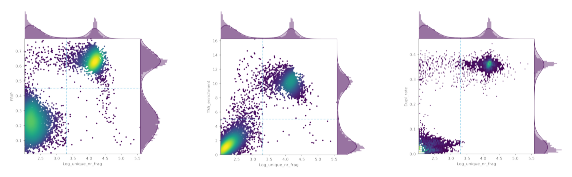

In [16]:
                         #[min,  #max]
QC_filters = {            
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]
    
}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)

# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
bc_passing_filters = {'10x_pbmc':[]}
bc_passing_filters['10x_pbmc'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['10x_pbmc'])} barcodes passed QC stats")

2521 barcodes passed QC stats


### Creating a cisTopic object and topic modeling

Now that we have good quality barcodes we will generate a binary count matrix of ATAC-seq fragments over consensus peaks. This matrix, along with metadata, will be stored in a cisTopic object and be used for topic modeling.

We will start by reading cell metadata from the scRNA-seq side of the analysis. For SCENIC+ we will only keep cells which passed quality metrics in both assays.

<div class="alert alert-info">

**Note:**

For independent scATAC-seq analysis you probably want to keep all cells (not only the cells passing the scRNA-seq filters). 
</div>

In [ ]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
scRNA_bc = adata.obs_names
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

Load scATAC-seq data

In [ ]:
import pickle
fragments_dict = {'10x_pbmc': os.path.join(work_dir, 'data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz')}
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= '../../pycisTopic/blacklist/hg38-blacklist.v2.bed'
metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

In [ ]:
print(f"{len(list(set(bc_passing_filters['10x_pbmc']) & set(scRNA_bc)))} cell barcodes pass both scATAC-seq and scRNA-seq based filtering")

2415 cell barcodes pass both scATAC-seq and scRNA-seq based filtering


Create cisTopic object

In [ ]:
from pycisTopic.cistopic_class import *
key = '10x_pbmc'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key]) & set(scRNA_bc)),
                            n_cpu=1,
                            project=key,
                            split_pattern='-')
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
print(cistopic_obj)

2022-08-04 09:16:19,076 cisTopic     INFO     Reading data for 10x_pbmc
2022-08-04 09:17:01,729 cisTopic     INFO     metrics provided!
2022-08-04 09:17:03,660 cisTopic     INFO     valid_bc provided, selecting barcodes!
2022-08-04 09:17:05,593 cisTopic     INFO     Counting fragments in regions
2022-08-04 09:17:18,288 cisTopic     INFO     Creating fragment matrix
2022-08-04 09:17:35,403 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-08-04 09:17:41,083 cisTopic     INFO     Removing blacklisted regions
2022-08-04 09:17:41,878 cisTopic     INFO     Creating CistopicObject
2022-08-04 09:17:42,871 cisTopic     INFO     Done!
Columns ['sample_id'] will be overwritten
CistopicObject from project 10x_pbmc with n_cells × n_regions = 2415 × 194062


Save object.

In [ ]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

Run topic modeling. The purpose of this is twofold:

1. To find sets of co-accessible regions (topics), this will be used downstream as candidate enhancers (together with Differentially Accessible Regions (DARs)).
2. To impute dropouts. 

<div class="alert alert-info">

**Note:**

scATAC-seq data is *very* sparse. This is because of the nature of the technique. It profiles chromatin accessibility in single cells and each cell only has two copies (two alleles) of each genomic region, also the genome is realtively large (so the number of regions which can be measured is large). For this reason drop outs are a *real* problem, the chance of measuring a specific genomic region (out of *many* potential regions) which only has two copies per cell is relatively small. Compare this to scRNA-seq analysis, here the number of genes which can be measure is relatively small (compared to the number of genomic regions) and each cell has potentially hundres of copies of each transcript. To account for drop outs in the scATAC-seq assay imputation techniques are often used, in this case we make use of topic modeling, making use of the fact that the data often contains cells which are quite similar to each other but might have slightly different features measured. 
</div>


Before running the topic modeling we are not sure what the best number of topics will be to explain the data. Analog to PCA where you also often don't know before hand what the best number of principle components is. For this reason we will generate models with increasing numbers of topics and after the fact choose the model with the optimal amount of topics. For demonstration purposes we will only try a few amount of models, you might want to explore a larger number of topics.

<div class="alert alert-warning">

**Warning:**

Topic modeling can be computationaly intense!
</div>

In [ ]:
import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.cistopic_class import *
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,4,10,16,32,48],
                    n_cpu=5,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

(run_cgs_model pid=13803) 2022-08-04 09:39:09,402 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=13804) 2022-08-04 09:39:09,404 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=13805) 2022-08-04 09:39:09,402 cisTopic     INFO     Running model with 32 topics
(run_cgs_model pid=13806) 2022-08-04 09:39:09,402 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=13802) 2022-08-04 09:39:09,402 cisTopic     INFO     Running model with 4 topics
(run_cgs_model pid=13806) 2022-08-04 09:45:30,724 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=13806) 2022-08-04 09:45:30,797 cisTopic     INFO     Running model with 48 topics
(run_cgs_model pid=13802) 2022-08-04 09:49:16,771 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=13803) 2022-08-04 09:59:39,401 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=13804) 2022-08-04 10:08:35,989 cisTopic     INFO     Model with 16 topics done!
(r

Save results

In [ ]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir, 'scATAC/models'))

pickle.dump(models,
            open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'wb'))

Analyze models.

We will make use of four quality metrics to select the model with the optimal amount of topics:
1. [Arun *et al.* 2010](http://link.springer.com/10.1007/978-3-642-13657-3_43)
2. [Cao & Juan *et al.* 2009](https://linkinghub.elsevier.com/retrieve/pii/S092523120800372X)
3. [Mimno *et al.* 2011](http://dirichlet.net/pdf/mimno11optimizing.pdf)
4. Log likelihood

For more information on these metrics see publications (linked above) and the [read the docs](https://pycistopic.readthedocs.io/en/latest/) page of pycisTopic.

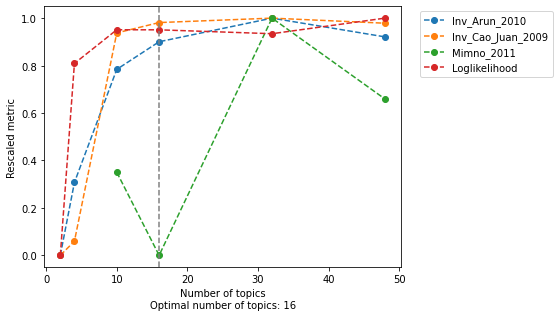

In [ ]:
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16, 
                       return_model=True, 
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

The metrics seem to stabelise with a model using 16 topics, so let's choose that model. 

In [ ]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

### Visualization

We can use the cell-topic probabilities to generate dimensionality reductions.

2022-08-04 11:30:48,959 cisTopic     INFO     Running UMAP


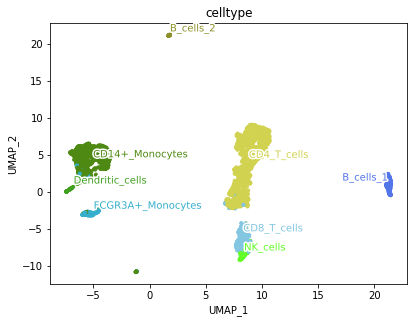

In [ ]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['celltype'])

We can also plot the cell-topic probabilities on the UMAP, to visualize their cell type specifiticy.

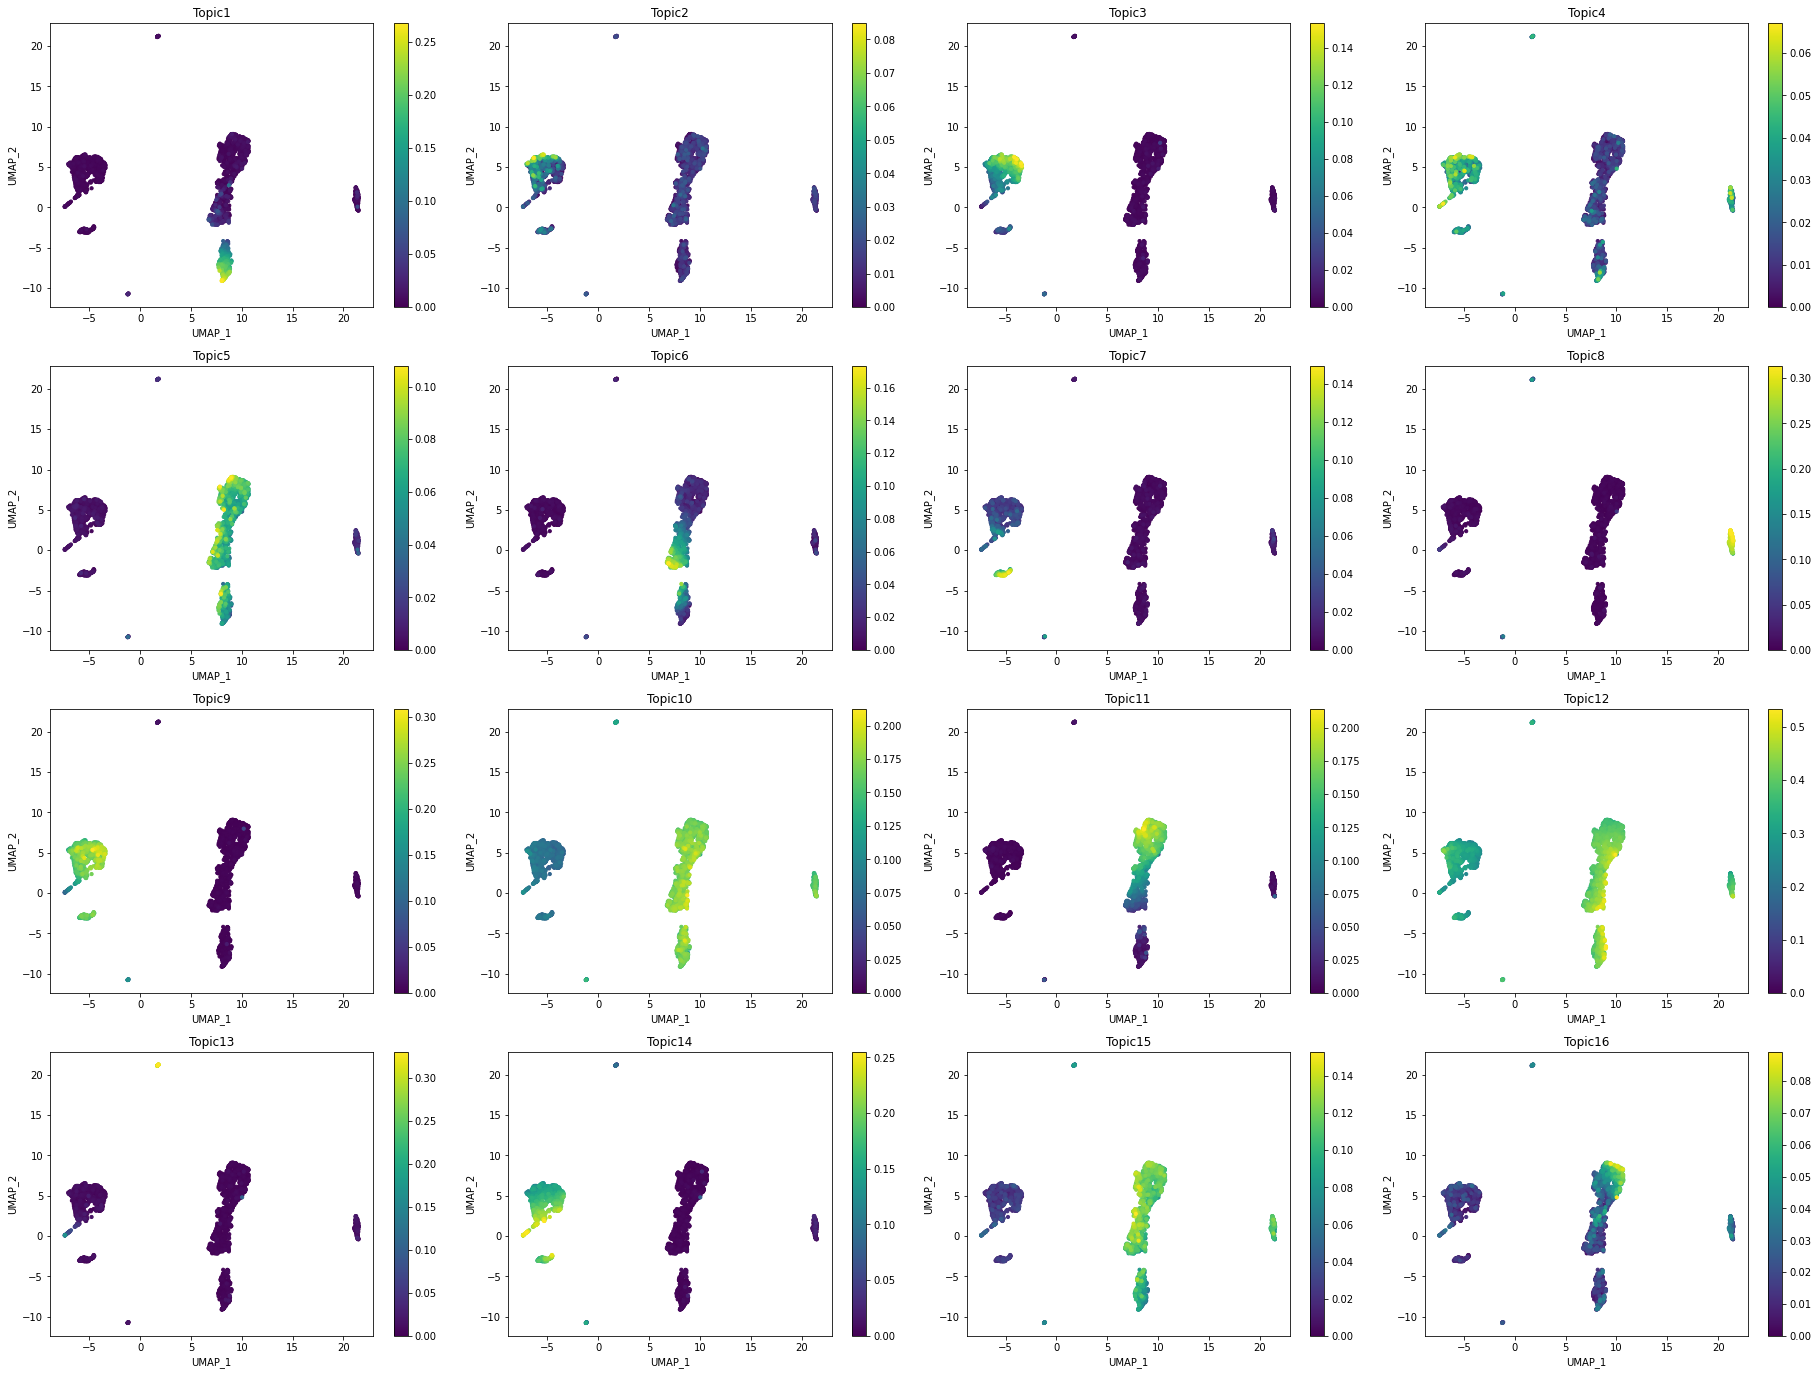

In [ ]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

For further analysis see the [pycisTopic read the docs page](https://pycistopic.readthedocs.io/en/latest/)

### Inferring candidate enhancer regions

Next we will infer candidate enhancer regions by:

1. binarization of region-topic probabilites.
2. calculation differentially accessibile regions (DARs) per cell type.

These regions will be used as input for the next step, [pycistarget](https://pycistarget.readthedocs.io/en/latest/), in which we will look which motifs are enriched in these regions.

First we will binarize the topics using the [otsu](http://ieeexplore.ieee.org/document/4310076/) method and by taking the top 3k regions per topic.

In [ ]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

Next we will calculate DARs per cell type

In [ ]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-')

2022-08-04 11:47:45,338 cisTopic     INFO     Imputing drop-outs
2022-08-04 11:47:46,586 cisTopic     INFO     Scaling
2022-08-04 11:47:47,670 cisTopic     INFO     Keep non zero rows
2022-08-04 11:47:49,654 cisTopic     INFO     Imputed accessibility sparsity: 0.43567783880139876
2022-08-04 11:47:49,655 cisTopic     INFO     Create CistopicImputedFeatures object
2022-08-04 11:47:49,656 cisTopic     INFO     Done!
2022-08-04 11:47:49,657 cisTopic     INFO     Normalizing imputed data
2022-08-04 11:47:57,846 cisTopic     INFO     Done!
2022-08-04 11:47:57,857 cisTopic     INFO     Calculating mean
2022-08-04 11:47:58,377 cisTopic     INFO     Calculating variance
2022-08-04 11:48:04,153 cisTopic     INFO     Done!
2022-08-04 11:48:04,820 cisTopic     INFO     Formatting data for B_cells_1
2022-08-04 11:48:06,159 cisTopic     INFO     Computing p-value for B_cells_1
2022-08-04 11:48:37,356 cisTopic     INFO     Computing log2FC for B_cells_1
2022-08-04 11:48:38,629 cisTopic     INFO     

<Figure size 432x288 with 0 Axes>

Save results

In [ ]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

We now completed all the mininal scATAC-seq preprocessing steps. 

In particular we:

1. generated a set of consensus peaks
2. performed quality control steps, only keeping cell barcods which passed QC metrics in both the scRNA-seq and scATAC-seq assay
3. performed topic modeling
4. inferred candidate enhancer regions by binarizing the region-topic probabilities and DARs per cell type

In the next step we will perform motif enrichment analysis on these candidate enhancer regions using the python package, [pycistarget](phttps://pycistarget.readthedocs.io/en/latest/). For this a precomputed motif-score database is needed. A sample specific database can be generated by scoring the consensus peaks with motifs or a general pre-scored database can be used as well.

## Motif enrichment analysis using pycistarget

After having identified candidate enhancer regions we will use [pycistarget](https://pycistarget.readthedocs.io/en/latest/) to find which motifs are enriched in these regions. 

### Cistarget databases

In order to run pycistarget one needs a precomputed database containing motif scores for genomic regions.

You can choose to compute this database yourself by scoring the consensus peaks generated in the scATAC-seq analysis using a set of motifs. The advantage of creating a sample specific database is that you can potentially pick up more target regions, given that only regions included/overlappig with regions in the cistarget database will be used for the SCENIC+ analysis. For more information checkout the [create_cisTarget_databases repo on github](https://github.com/aertslab/create_cisTarget_databases). 

We also provide several precomputed databases containing regions covering many experimentally defined candidate cis-regulatory elements. These databases are available on: [https://resources.aertslab.org/cistarget/](https://resources.aertslab.org/cistarget/).

For this analysis we will use a precomputed database using [screen regions](https://screen.encodeproject.org/).

Next to a precomputed motif database we also need a motif-to-tf annotation database. This is also available on [https://resources.aertslab.org/cistarget/](https://resources.aertslab.org/cistarget/).

Load candidate enhancer regions identified in previous step.

In [3]:
import pickle
region_bin_topics_otsu = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'rb'))
region_bin_topics_top3k = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'rb'))
markers_dict = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'rb'))

Convert to dictionary of pyranges objects.

In [4]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [5]:
for key in region_sets.keys():
    print(f'{key}: {region_sets[key].keys()}')

topics_otsu: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
topics_top_3: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
DARs: dict_keys(['B_cells_1', 'B_cells_2', 'CD14+_Monocytes', 'CD4_T_cells', 'CD8_T_cells', 'Dendritic_cells', 'FCGR3A+_Monocytes', 'NK_cells'])


Define rankings, score and motif annotation database.

The ranking database is used for running the cistarget analysis and the scores database is used for running the DEM analysis. For more information see [the pycistarget read the docs page](https://pycistarget.readthedocs.io/en/latest/)


In [6]:
db_fpath = "/staging/leuven/stg_00002/lcb/icistarget/data/make_rankings/v10_clust/CTX_hg38"
motif_annot_fpath = "/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10_no_desso_no_factorbook/snapshots"

In [7]:
rankings_db = os.path.join(db_fpath, 'cluster_SCREEN.regions_vs_motifs.rankings.v2.feather')
scores_db =  os.path.join(db_fpath, 'cluster_SCREEN.regions_vs_motifs.scores.v2.feather')
motif_annotation = os.path.join(motif_annot_fpath, 'motifs-v10-nr.hgnc-m0.00001-o0.0.tbl')

Next we will run pycistarget using the `run_pycistarget` wrapper function.

This function will run cistarget based and DEM based motif enrichment analysis with or without promoter regions.


In [8]:
if not os.path.exists(os.path.join(work_dir, 'motifs')):
    os.makedirs(os.path.join(work_dir, 'motifs'))

In [9]:
from scenicplus.wrappers.run_pycistarget import run_pycistarget
run_pycistarget(
    region_sets = region_sets,
    species = 'homo_sapiens',
    save_path = os.path.join(work_dir, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 8,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    annotation_version = 'v10nr_clust',
    )

2022-08-05 08:53:16,277 pycisTarget_wrapper INFO     pbmc_tutorial/motifs folder already exists.
2022-08-05 08:53:17,650 pycisTarget_wrapper INFO     Loading cisTarget database for topics_otsu
2022-08-05 08:53:17,653 cisTarget    INFO     Reading cisTarget database
2022-08-05 09:13:51,198 pycisTarget_wrapper INFO     Running cisTarget for topics_otsu


(ctx_internal_ray pid=17049) 2022-08-05 09:14:38,091 cisTarget    INFO     Running cisTarget for Topic1 which has 4760 regions
(ctx_internal_ray pid=17050) 2022-08-05 09:14:38,555 cisTarget    INFO     Running cisTarget for Topic2 which has 6170 regions
(ctx_internal_ray pid=17047) 2022-08-05 09:14:38,925 cisTarget    INFO     Running cisTarget for Topic3 which has 4559 regions
(ctx_internal_ray pid=17040) 2022-08-05 09:14:39,376 cisTarget    INFO     Running cisTarget for Topic4 which has 3273 regions
(ctx_internal_ray pid=17043) 2022-08-05 09:14:39,819 cisTarget    INFO     Running cisTarget for Topic5 which has 2115 regions
(ctx_internal_ray pid=17044) 2022-08-05 09:14:40,172 cisTarget    INFO     Running cisTarget for Topic6 which has 3547 regions
(ctx_internal_ray pid=17046) 2022-08-05 09:14:40,636 cisTarget    INFO     Running cisTarget for Topic7 which has 5380 regions
(ctx_internal_ray pid=17048) 2022-08-05 09:14:41,022 cisTarget    INFO     Running cisTarget for Topic8 which h

2022-08-05 09:16:13,911	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8266


2022-08-05 09:17:31,790 cisTarget    INFO     Done!
2022-08-05 09:17:31,793 pycisTarget_wrapper INFO     pbmc_tutorial/motifs/CTX_topics_otsu_No_promoters folder already exists.
2022-08-05 09:17:32,015 pycisTarget_wrapper INFO     Running DEM for topics_otsu
2022-08-05 09:17:32,017 DEM          INFO     Reading DEM database


Let's explore some of the results. Below we show the motifs found for topic 8 (specific to B-cells) using DEM.

In [3]:
import dill
menr = dill.load(open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb'))

In [8]:
menr['DEM_topics_otsu_All'].DEM_results('Topic8')

,Logo,Contrast,Direct_annot,Orthology_annot,Log2FC,Adjusted_pval,Mean_fg,Mean_bg,Motif_hit_thr,Motif_hits
metacluster_70.24,,Topic8,POU3F2,NaN,2.033431,0.007407,0.417515,0.101988,3.0,436.0
metacluster_70.25,,Topic8,POU3F4,NaN,1.87856,0.010579,0.431751,0.117417,3.0,439.0
metacluster_70.20,,Topic8,POU1F1,NaN,1.808349,0.02941,0.44035,0.125728,3.0,420.0
metacluster_70.14,,Topic8,POU2F3,NaN,1.583922,0.002572,0.538298,0.179562,3.0,516.0
metacluster_142.5,,Topic8,POU2F2,NaN,1.422996,0.001821,0.559761,0.208755,3.0,462.0
taipale_tf_pairs__POU5F1_NATATGCTAATKN_HT,,Topic8,POU5F1,NaN,1.315945,0.011452,0.563511,0.226341,3.0,533.0
homer__ATATGCAAAT_Oct2,,Topic8,NaN,POU2F2,1.298874,0.005947,0.731667,0.297381,3.0,656.0
metacluster_70.15,,Topic8,POU2F2,NaN,1.275756,0.005288,0.622926,0.257274,3.0,577.0
tfdimers__MD00527,,Topic8,"ZEB1, IRF1, IRF7, IRF6, IRF8, IRF4, IRF5, IRF2, IRF3",NaN,1.247605,0.032119,0.495943,0.208865,3.0,495.0
metacluster_70.4,,Topic8,POU3F2,NaN,1.11287,0.001088,0.638315,0.29514,3.0,572.0


We now have completed all the steps necessary for starting the SCENIC+ analysis 😅.

In particalular, we have

1. preprocessed the scRNA-seq side of the data, selecting high quality cells and annotation these cells.
2. preprocessed the scATAC-seq side of the data, selecting high quality cells, performing topic modeling and identifying candidate enhacer regions.
3. looked for enriched motifs in candidate enhancer regions.

In the next section we will combine all these analysis and run SCENIC+


## inferring enhancer-driven Gene Regulatory Networks (eGRNs) using SCENIC+

We now have completed all the steps for running the SCENIC+ analysis. 

We will start by creating a scenicplus object containing all the analysis we have done up to this point.

For this we will need to load:

1. the AnnData object containing the scRNA-seq side of the analysis.
2. the cisTopic object containing the scATAC-seq side of the analysis.
3. the motif enrichment dictionary containing the motif enrichment results.

In [6]:
import dill
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import pandas
import pyranges
# Set stderr to null to avoid strange messages from ray
import sys
_stderr = sys.stderr                                                         
null = open(os.devnull,'wb')
work_dir = 'pbmc_tutorial'
tmp_dir = '/scratch/leuven/330/vsc33053/'

adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
cistopic_obj = dill.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
menr = dill.load(open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb'))

Create the SCENIC+ object. It will store both the gene expression and chromatin accessibility along with motif enrichment results and cell/region/gene metadata.

Cell metadata comming from the cistopic_obj will be prefixed with the string `ACC_` and metadata comming from the adata object will be prefixed with the string `GEX_`.

In [7]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata.raw.to_adata(),
    cisTopic_obj = cistopic_obj,
    menr = menr,
    bc_transform_func = lambda x: f'{x}-10x_pbmc' #function to convert scATAC-seq barcodes to scRNA-seq ones
)
scplus_obj.X_EXP = np.array(scplus_obj.X_EXP.todense())
scplus_obj

2022-08-09 21:06:11,028 cisTopic     INFO     Imputing drop-outs
2022-08-09 21:06:19,958 cisTopic     INFO     Scaling
2022-08-09 21:06:21,803 cisTopic     INFO     Keep non zero rows
2022-08-09 21:06:24,861 cisTopic     INFO     Imputed accessibility sparsity: 0.43567783880139876
2022-08-09 21:06:24,863 cisTopic     INFO     Create CistopicImputedFeatures object
2022-08-09 21:06:24,864 cisTopic     INFO     Done!


SCENIC+ object with n_cells x n_genes = 2415 x 21255 and n_cells x n_regions = 2415 x 191245
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'GEX_n_genes', 'GEX_doublet_score', 'GEX_predicted_doublet', 'GEX_n_genes_by_counts', 'GEX_total_counts', 'GEX_total_counts_mt', 'GEX_pct_counts_mt', 'GEX_ingest_celltype_label', 'GEX_leiden_res_0.8', 'GEX_celltype', 'ACC_barcode', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_acc', 'ACC_Total_nr_frag_in_regions', 'ACC_cisTopic_nr_acc', 'ACC_TSS_enrichment', 'ACC_Log_total_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_Unique_nr_frag', 'ACC_Dupl_nr_frag', 'ACC_FRIP', 'ACC_Log_unique_nr_frag', 'ACC_Unique_nr_frag_in_regions', 'ACC_Dupl_rate', 'ACC_Total_nr_frag', 'ACC_n_genes', 'ACC_doublet_score', 'A

<div class="alert alert-info">

**Note:**

the scenicplus package contains many function, if you need help with any of them just run the `help()` function. For example see below:
</div>

In [7]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
help(create_SCENICPLUS_object)

Help on function create_SCENICPLUS_object in module scenicplus.scenicplus_class:

create_SCENICPLUS_object(GEX_anndata: anndata._core.anndata.AnnData, cisTopic_obj: pycisTopic.cistopic_class.CistopicObject, menr: Mapping[str, Mapping[str, Any]], multi_ome_mode: bool = True, nr_metacells: Union[int, Mapping[str, int]] = None, nr_cells_per_metacells: Union[int, Mapping[str, int]] = 10, meta_cell_split: str = '_', key_to_group_by: str = None, imputed_acc_obj: pycisTopic.diff_features.CistopicImputedFeatures = None, imputed_acc_kwargs: Mapping[str, Any] = {'scale_factor': 1000000}, normalize_imputed_acc: bool = False, normalize_imputed_acc_kwargs: Mapping[str, Any] = {'scale_factor': 10000}, cell_metadata: pandas.core.frame.DataFrame = None, region_metadata: pandas.core.frame.DataFrame = None, gene_metadata: pandas.core.frame.DataFrame = None, bc_transform_func: Callable = None, ACC_prefix: str = 'ACC_', GEX_prefix: str = 'GEX_') -> scenicplus.scenicplus_class.SCENICPLUS
    Function to cr

Before running SCENIC+ it is important to check with which biomart host the gene names used in your analysis match best. Biomart will be used to find transcription starting sites of each gene. The names of genes (symbols) change quite often, so it is important to select the biomart host with the largest overlap, otherwise a lot of genes can potentially be lost. 

Below we show an example on how to select the optimal host.

In [21]:
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',                        
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',                        
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',      
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}
    
import pybiomart as pbm
def test_ensembl_host(scplus_obj, host, species):
    dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
    annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    annot['Chromosome'] = annot['Chromosome'].astype('str')
    filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
    annot = annot[~filter]
    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    gene_names_release = set(annot['Gene'].tolist())
    ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
    print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
    return ov

n_overlap = {}
for version in ensembl_version_dict.keys():
    print(f'host: {version}')
    try:
        n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'hsapiens')
    except:
        print('Host not reachable')
v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105
Genes recovered: 16357 out of 21255
host: 104
Genes recovered: 16486 out of 21255
host: 103
Genes recovered: 20757 out of 21255
host: 102


/user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pybiomart/dataset.py:269: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(StringIO(response.text), sep='\t')


Genes recovered: 20803 out of 21255
host: 101
Genes recovered: 20877 out of 21255
host: 100
Genes recovered: 20978 out of 21255
host: 99
Genes recovered: 21027 out of 21255
host: 98
Genes recovered: 21231 out of 21255
host: 97
Genes recovered: 20989 out of 21255
host: 96
Genes recovered: 20407 out of 21255
host: 95
Genes recovered: 20292 out of 21255
host: 94
Genes recovered: 20231 out of 21255
host: 93
Genes recovered: 20089 out of 21255
host: 92
Genes recovered: 20003 out of 21255
host: 91
Genes recovered: 19862 out of 21255
host: 90
Genes recovered: 19837 out of 21255
host: 89
Genes recovered: 19759 out of 21255
host: 88
Genes recovered: 16160 out of 21255
host: 87
Host not reachable
host: 86
Host not reachable
host: 80
Genes recovered: 15943 out of 21255
host: 77
Genes recovered: 15714 out of 21255
host: 75
Host not reachable
host: 54
Host not reachable
version: 98 has the largest overlap, use http://sep2019.archive.ensembl.org/ as biomart host


Once the object is created we can run SCENIC+. The whole analysis workflow can be run using a single wrapper function or each step can be run individually.

<div class="alert alert-info">

**Note:**

Here we will use the wrapper function. For more information on the different steps, see the following tutorial: TO BE ADDED. 
</div>

In [9]:
biomart_host = "http://sep2019.archive.ensembl.org/"

Before running we will also download a list of known human TFs from the [human transcription factors database](http://humantfs.ccbr.utoronto.ca/).

In [26]:
!wget -O pbmc_tutorial/data/utoronto_human_tfs_v_1.01.txt  http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt

--2022-08-05 13:59:20--  http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt
Resolving humantfs.ccbr.utoronto.ca (humantfs.ccbr.utoronto.ca)... 142.150.52.218
Connecting to humantfs.ccbr.utoronto.ca (humantfs.ccbr.utoronto.ca)|142.150.52.218|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11838 (12K) [text/plain]
Saving to: ‘pbmc_tutorial/data/utoronto_human_tfs_v_1.01.txt’

100%[======================================>] 11,838      53.9KB/s   in 0.2s   

2022-08-05 13:59:21 (53.9 KB/s) - ‘pbmc_tutorial/data/utoronto_human_tfs_v_1.01.txt’ saved [11838/11838]



We will also download a the program bedToBigBed this will be used to generate files which can be uploaded to the UCSC genome browser

In [27]:
!wget -O pbmc_tutorial/bedToBigBed http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bedToBigBed
!chmod +x pbmc_tutorial/bedToBigBed

--2022-08-05 14:01:55--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bedToBigBed
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9573136 (9.1M)
Saving to: ‘pbmc_tutorial/bedToBigBed’

100%[======================================>] 9,573,136   3.95MB/s   in 2.3s   

2022-08-05 14:01:58 (3.95 MB/s) - ‘pbmc_tutorial/bedToBigBed’ saved [9573136/9573136]



In [18]:
#only keep the first two columns of the PCA embedding in order to be able to visualize this in SCope
scplus_obj.dr_cell['GEX_X_pca'] = scplus_obj.dr_cell['GEX_X_pca'].iloc[:, 0:2]
scplus_obj.dr_cell['GEX_rep'] = scplus_obj.dr_cell['GEX_rep'].iloc[:, 0:2]

Now we are ready to run the analysis. 

<div class="alert alert-warning">

**Warning:**

Running SCENIC+ can be computationaly expensive. We don't recommend to run it on your local machine.
</div>

In [25]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['GEX_celltype'],
        species = 'hsapiens',
        assembly = 'hg38',
        tf_file = 'pbmc_tutorial/data/utoronto_human_tfs_v_1.01.txt',
        save_path = os.path.join(work_dir, 'scenicplus'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = True,
        calculate_DEGs_DARs = True,
        export_to_loom_file = True,
        export_to_UCSC_file = True,
        path_bedToBigBed = 'pbmc_tutorial',
        n_cpu = 12,
        _temp_dir = os.path.join(tmp_dir, 'ray_spill'))
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)
    raise(e)

2022-08-10 00:06:08,510 SCENIC+_wrapper INFO     pbmc_tutorial/scenicplus folder already exists.
2022-08-09 21:07:44,695 SCENIC+_wrapper INFO     Merging cistromes
2022-08-09 21:15:49,444 SCENIC+_wrapper INFO     Getting search space
2022-08-09 21:15:50,331 R2G          INFO     Downloading gene annotation from biomart dataset: hsapiens_gene_ensembl
2022-08-09 21:16:08,074 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
2022-08-09 21:16:09,168 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2022-08-09 21:16:11,431 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2022-08-09 21:16:30,513 R2G          INFO     Intersecting with regions.


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


2022-08-09 21:16:31,403 R2G          INFO     Calculating distances from region to gene
2022-08-09 21:18:05,997 R2G          INFO     Imploding multiple entries per region and gene
2022-08-09 21:20:31,736 R2G          INFO     Done!
2022-08-09 21:20:32,158 SCENIC+_wrapper INFO     Inferring region to gene relationships
2022-08-09 21:20:32,330 R2G          INFO     Calculating region to gene importances, using GBM method


2022-08-09 21:20:37,215	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265
Running using 12 cores: 100%|███████████████████████████████████████████| 14676/14676 [00:29<00:00, 493.40it/s]


2022-08-09 21:34:41,966 R2G          INFO     Took 849.634777545929 seconds
2022-08-09 21:34:41,968 R2G          INFO     Calculating region to gene correlation, using SR method


2022-08-09 21:34:46,611	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265
initializing:   1%|▋                                                       | 164/14676 [00:09<14:13, 17.00it/s](_score_regions_to_single_gene_ray pid=22224) /user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
(_score_regions_to_single_gene_ray pid=22224)   warnings.warn(stats.ConstantInputWarning(warn_msg))
initializing:   1%|▋                                                       | 176/14676 [00:10<14:09, 17.06it/s](_score_regions_to_single_gene_ray pid=22235) /user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
(_score_regions_to_single_gene_ray pid=22235)  

2022-08-09 21:48:29,014 R2G          INFO     Took 827.04399061203 seconds
2022-08-09 21:48:40,327 R2G          INFO     Done!
2022-08-09 21:48:40,715 SCENIC+_wrapper INFO     Inferring TF to gene relationships


2022-08-09 21:48:48,960	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


2022-08-09 21:48:48,960	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


initializing:  10%|█████▌                                                 | 2168/21255 [01:15<20:16, 15.69it/s](raylet) Spilled 2279 MiB, 32 objects, write throughput 192 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 4145 MiB, 58 objects, write throughput 260 MiB/s.
Running using 12 cores: 100%|███████████████████████████████████████████| 21255/21255 [01:16<00:00, 278.59it/s]


2022-08-09 22:15:31,375 TF2G         INFO     Took 1599.8746180534363 seconds
2022-08-09 22:15:31,379 TF2G         INFO     Adding correlation coefficients to adjacencies.
2022-08-09 22:16:06,074 TF2G         INFO     Warning: adding TFs as their own target to adjecencies matrix. Importance values will be max + 1e-05
2022-08-09 22:16:17,002 TF2G         INFO     Adding importance x rho scores to adjacencies.
2022-08-09 22:16:17,053 TF2G         INFO     Took 45.67378568649292 seconds
2022-08-09 22:16:17,482 SCENIC+_wrapper INFO     Build eGRN
2022-08-09 22:16:17,486 GSEA         INFO     Thresholding region to gene relationships


2022-08-09 22:16:40,569	ERROR services.py:1488 -- Failed to start the dashboard: Failed to start the dashboard
 The last 10 lines of /scratch/leuven/330/vsc33053/ray_spill/session_2022-08-09_22-16-17_762354_24083/logs/dashboard.log:
2022-08-09 22:16:36,145	INFO utils.py:99 -- Get all modules by type: DashboardHeadModule

2022-08-09 22:16:40,575	ERROR services.py:1489 -- Failed to start the dashboard
 The last 10 lines of /scratch/leuven/330/vsc33053/ray_spill/session_2022-08-09_22-16-17_762354_24083/logs/dashboard.log:
2022-08-09 22:16:36,145	INFO utils.py:99 -- Get all modules by type: DashboardHeadModule
Traceback (most recent call last):
  File "/user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/ray/_private/services.py", line 1465, in start_dashboard
    raise Exception(err_msg + last_log_str)
Exception: Failed to start the dashboard
 The last 10 lines of /scratch/leuven/330/vsc33053/ray_spill/session_2022-08-09_22-16-17_762354_24083/log

2022-08-09 22:36:04,805 GSEA         INFO     Subsetting TF2G adjacencies for TF with motif.


2022-08-09 22:36:11,708	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8266


2022-08-09 22:36:15,228 GSEA         INFO     Running GSEA...


Running using 12 cores: 100%|███████████████| 30584/30584 [06:18<00:00, 80.79it/s]


2022-08-09 22:55:52,226 GSEA         INFO     Subsetting on adjusted pvalue: 1, minimal NES: 0 and minimal leading edge genes 10
2022-08-09 22:56:00,036 GSEA         INFO     Merging eRegulons
2022-08-09 22:56:02,199 GSEA         INFO     Storing eRegulons in .uns[eRegulons].
2022-08-09 22:56:30,771 SCENIC+_wrapper INFO     Formatting eGRNs
2022-08-09 23:12:13,820 SCENIC+_wrapper INFO     Converting eGRNs to signatures
2022-08-09 23:13:50,922 SCENIC+_wrapper INFO     Calculating eGRNs AUC
2022-08-09 23:13:50,926 SCENIC+_wrapper INFO     Calculating region ranking
2022-08-09 23:16:00,602 SCENIC+_wrapper INFO     Calculating eGRNs region based AUC
2022-08-09 23:16:37,138 SCENIC+_wrapper INFO     Calculating gene ranking
2022-08-09 23:16:47,672 SCENIC+_wrapper INFO     Calculating eGRNs gene based AUC
2022-08-09 23:17:09,299 SCENIC+_wrapper INFO     Calculating TF-eGRNs AUC correlation
2022-08-09 23:17:28,778 SCENIC+_wrapper INFO     Binarizing eGRNs AUC
2022-08-09 23:30:18,591 SCENIC+_wr

... storing 'ACC_celltype' as categorical
... storing 'ACC_sample_id' as categorical


2022-08-09 23:32:41,037 SCENIC+      INFO     Finished calculating DEGs for variable GEX_celltype
2022-08-09 23:32:41,039 SCENIC+      INFO     Calculating DARs for variable GEX_celltype
2022-08-09 23:33:04,892 SCENIC+      INFO     There are 54507 variable features


... storing 'ACC_celltype' as categorical
... storing 'ACC_sample_id' as categorical


2022-08-09 23:33:32,449 SCENIC+      INFO     Finished calculating DARs for variable GEX_celltype
2022-08-09 23:33:32,454 SCENIC+_wrapper INFO     Exporting to loom file
2022-08-09 23:33:32,456 SCENIC+      INFO     Formatting data
2022-08-09 23:33:32,478 SCENIC+      INFO     The number of regulons is more than > 900. keep_direct_and_extended_if_not_direct is set to True
2022-08-09 23:34:22,821 SCENIC+      INFO     Creating minimal loom
2022-08-09 23:57:22,659 SCENIC+      INFO     Adding annotations
2022-08-09 23:57:24,056 SCENIC+      INFO     Adding clusterings
2022-08-09 23:57:24,080 SCENIC+      INFO     Adding markers
2022-08-09 23:57:24,376 SCENIC+      INFO     Exporting
2022-08-09 23:57:31,189 SCENIC+      INFO     Formatting data
2022-08-09 23:57:31,208 SCENIC+      INFO     The number of regulons is more than > 900. keep_direct_and_extended_if_not_direct is set to True
2022-08-09 23:58:46,626 SCENIC+      INFO     Creating minimal loom
2022-08-10 00:00:06,487 SCENIC+      

## Note on the output of SCENIC+

After running the SCENIC+ analysis the `scplus_obj` will be populated with the results of several analysis. Below we will describe how you can explore these.

For structuring this data we took inspiration from the [AnnData](https://anndata.readthedocs.io/en/latest/) format.

In [3]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 2415 x 21255 and n_cells x n_regions = 2415 x 191245
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'GEX_n_genes', 'GEX_doublet_score', 'GEX_predicted_doublet', 'GEX_n_genes_by_counts', 'GEX_total_counts', 'GEX_total_counts_mt', 'GEX_pct_counts_mt', 'GEX_ingest_celltype_label', 'GEX_leiden_res_0.8', 'GEX_celltype', 'ACC_barcode', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_acc', 'ACC_Total_nr_frag_in_regions', 'ACC_cisTopic_nr_acc', 'ACC_TSS_enrichment', 'ACC_Log_total_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_Unique_nr_frag', 'ACC_Dupl_nr_frag', 'ACC_FRIP', 'ACC_Log_unique_nr_frag', 'ACC_Unique_nr_frag_in_regions', 'ACC_Dupl_rate', 'ACC_Total_nr_frag', 'ACC_n_genes', 'ACC_doublet_score', 'A

### Gene expression and chromatin accessibility data

Both the raw gene expression counts and chromatin accessibility data are stored in the `scplus_obj` and can be accessed by running, `scplus_obj.to_df('EXP')` or `scplus_obj.to_df('ACC')`.

In [ ]:
scplus_obj.to_df('EXP').head()

,AL627309.1,AL627309.5,AL627309.4,AL669831.2,LINC01409,LINC01128,LINC00115,FAM41C,AL645608.2,SAMD11,...,MT-ND6,MT-CYB,AC145212.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1,AC004556.3,AC007325.4
CCCTCACCACTAAGTT-1-10x_pbmc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GAGCTGCTCCTGTTCA-1-10x_pbmc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCTCGCCCACCTCAGG-1-10x_pbmc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,29.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GTCAATATCCCATAAA-1-10x_pbmc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGTTAGCATGAATAG-1-10x_pbmc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
scplus_obj.to_df('ACC').head()

,CCCTCACCACTAAGTT-1-10x_pbmc,GAGCTGCTCCTGTTCA-1-10x_pbmc,TCTCGCCCACCTCAGG-1-10x_pbmc,GTCAATATCCCATAAA-1-10x_pbmc,TCGTTAGCATGAATAG-1-10x_pbmc,GATCAGTTCTCTAGCC-1-10x_pbmc,GTTTGTTTCCGGTATG-1-10x_pbmc,CCGCACACAGTTTCTC-1-10x_pbmc,AGTCAAGAGTCATTAG-1-10x_pbmc,AAGCGTTTCATTGTCT-1-10x_pbmc,...,CCATATTTCCTCCTAA-1-10x_pbmc,GAGGTACAGGACCGCT-1-10x_pbmc,GCGCTAGGTCAAAGGG-1-10x_pbmc,AAATGCCTCCAGGAAA-1-10x_pbmc,TATTCGTTCTTGCAAA-1-10x_pbmc,AAGGCCCTCTTGATGA-1-10x_pbmc,ACTCGCTTCATGAAGG-1-10x_pbmc,CCTACTGGTCAAGTGC-1-10x_pbmc,GTCCGTAAGTTACCGG-1-10x_pbmc,GAAGCTAAGTTAGAGG-1-10x_pbmc
GL000194.1:101175-101675,0,7,0,0,6,0,0,0,1,2,...,0,1,0,0,0,0,1,0,0,9
GL000194.1:114712-115212,1,2,1,1,1,2,2,1,1,1,...,2,2,1,2,1,2,1,1,2,1
GL000195.1:22453-22953,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
GL000195.1:30601-31101,32,25,33,35,24,32,19,28,24,21,...,20,22,28,19,27,18,29,31,33,24
GL000195.1:32233-32733,12,14,14,13,12,16,10,12,13,11,...,11,12,13,12,12,12,13,17,14,12


### Cell, region and gene metadata

Cell metatdata is stored in the `.metadata_cell` slot. Data comming from the gene expression side is prefixed with the string `GEX_` ad data comming from the chromatin accessibility side is prefixed with the string `ACC_`.

Region metadata is stored in the `.metadata_region` slot.

Gene metadata is stored in the `.metadata_gene` slot.

In [16]:
scplus_obj.metadata_cell.head()

,GEX_n_genes,GEX_doublet_score,GEX_predicted_doublet,GEX_n_genes_by_counts,GEX_total_counts,GEX_total_counts_mt,GEX_pct_counts_mt,GEX_ingest_celltype_label,GEX_leiden_res_0.8,GEX_celltype,...,ACC_doublet_score,ACC_predicted_doublet,ACC_n_genes_by_counts,ACC_total_counts,ACC_total_counts_mt,ACC_pct_counts_mt,ACC_ingest_celltype_label,ACC_leiden_res_0.8,ACC_celltype,ACC_sample_id
CCCTCACCACTAAGTT-1-10x_pbmc,1684,0.046595,False,1683,3535.0,219.0,6.195191,CD4 T cells,0,CD4_T_cells,...,0.046595,False,1683,3535.0,219.0,6.195191,CD4 T cells,0,CD4_T_cells,10x_pbmc
GAGCTGCTCCTGTTCA-1-10x_pbmc,1377,0.013972,False,1374,2356.0,222.0,9.422750,NK cells,9,NK_cells,...,0.013972,False,1374,2356.0,222.0,9.422750,NK cells,9,NK_cells,10x_pbmc
TCTCGCCCACCTCAGG-1-10x_pbmc,1517,0.064877,False,1517,2746.0,285.0,10.378733,CD4 T cells,0,CD4_T_cells,...,0.064877,False,1517,2746.0,285.0,10.378733,CD4 T cells,0,CD4_T_cells,10x_pbmc
GTCAATATCCCATAAA-1-10x_pbmc,1157,0.018142,False,1157,2984.0,84.0,2.815013,CD4 T cells,0,CD4_T_cells,...,0.018142,False,1157,2984.0,84.0,2.815013,CD4 T cells,0,CD4_T_cells,10x_pbmc
TCGTTAGCATGAATAG-1-10x_pbmc,1589,0.008130,False,1589,3111.0,275.0,8.839602,CD8 T cells,5,CD8_T_cells,...,0.008130,False,1589,3111.0,275.0,8.839602,CD8 T cells,5,CD8_T_cells,10x_pbmc


In [17]:
scplus_obj.metadata_regions.head()

,Chromosome,Start,End,Width,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc
GL000194.1:101175-101675,GL000194.1,101175,101675,500,27,1.431364,24,1.380211
GL000194.1:114712-115212,GL000194.1,114712,115212,500,44,1.643453,44,1.643453
GL000195.1:22453-22953,GL000195.1,22453,22953,500,7,0.845098,7,0.845098
GL000195.1:30601-31101,GL000195.1,30601,31101,500,608,2.783904,525,2.720159
GL000195.1:32233-32733,GL000195.1,32233,32733,500,278,2.444045,258,2.411620


In [19]:
scplus_obj.metadata_genes.head()

,gene_ids,feature_types,genome,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,28,False,27,0.010247,98.975332,27.0
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,145,False,140,0.060342,94.686907,159.0
AL627309.4,ENSG00000241599,Gene Expression,GRCh38,9,False,9,0.003416,99.658444,9.0
AL669831.2,ENSG00000229905,Gene Expression,GRCh38,4,False,4,0.001518,99.848197,4.0
LINC01409,ENSG00000237491,Gene Expression,GRCh38,143,False,140,0.058824,94.686907,155.0


### Motif enrichment data

Motif enrichment data is stored in the `.menr` slot.

In [20]:
scplus_obj.menr.keys()

dict_keys(['CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'])

### Dimensionality reduction data

Dimensionality reductions of the cells are stored in the `.dr_cell` slot. Reductions comming from the gene expression side of the data are prefixed with the string `GEX_` and those comming from the chromatin accessibility side with `ACC_`.

IF region based dimensionality reductions were calculated then those will be stored in the `.dr_region` slote (not the case in this example).

In [21]:
scplus_obj.dr_cell.keys()

dict_keys(['GEX_X_pca', 'GEX_X_umap', 'GEX_rep', 'eRegulons_UMAP', 'eRegulons_tSNE'])

### Unstructured data

Additional unstructured data will be stored in the `.uns` slot. After running the standard scenicplus wrapper function this slot will contain the following entries:

1. `Cistromes`: this contains TFs together with target regions based on the motif enrichment analysis (i.e. **prior to running SCENIC+**)
2. `search_space`: this is a dataframe containing the search space for each gene.
3. `region_to_gene`: this is a dataframe containing region to gene links **prior to running SCENIC+** (i.e unfiltered/raw region to gene importance scores and correlation coefficients).
4. `TF2G_adj`: this is a datafram containing TF to gene links **prior to running SCENIC+** (i.e unfiltered/raw TF to gene importance scores and correlation coefficients).

These four slots contain all the data necessary for running the SCENIC+ analysis. The following entries are produced by the SCENIC+ analysis:

1. `eRegulons`: this is the raw output from the SCENIC+ analysis. We will go into a bit more detail for these below.
2. `eRegulon_metadata`: this is a dataframe containing the same information as `eRegulons` bit in a format which is a bit easier to parse for a human.
3. `eRegulon_signatures`: this is a dictionary with target regions and genes for each eRegulon
4. `eRegulon_AUC`: this slot contains dataframes with eRegulon enrichment scores calculated using AUCell (see below).
5. `pseudobulk`: contains pseudobulked gene expression and chromatin accessibility data, this is used to calculated TF to eRegulon correlation values.
6. `TF_cistrome_correlation`: contains correlation values between TF expression and eRegulon enrichment scores (seperate entries for target gene and target region based scores).
7. `eRegulon_AUC_thresholds`: contains thresholds on the AUC values (eRegulon enrichment scores), this is necessary to be able to visualize the results in [SCope](https://scope.aertslab.org/)
8. `RSS`: contains eRegulon Specificity Scores (RSS), a measure on how cell type specific an eRegulon is.
9. `DEGs`: contains Differentially Expressed Genes.
10. `DARs`: contains Differentially Accessibile Regions. 

In [23]:
scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'Pseudobulk', 'TF_cistrome_correlation', 'eRegulon_AUC_thresholds', 'RSS', 'DEGs', 'DARs'])

#### The eRegulons entry

The main output of SCENIC+ are eRegulons.

This is initially stored in a list of `eRegulon` classes as depicted below.

In [12]:
scplus_obj.uns['eRegulons'][0:5]

[eRegulon for TF ARID3A in context frozenset({'0.95 quantile', 'Top 15 region-to-gene links per gene', 'BASC binarized', 'positive r2g', '0.9 quantile', '0.85 quantile', 'positive tf2g', 'Cistromes_Unfiltered', 'Top 10 region-to-gene links per gene'}).
 	This eRegulon has 364 target regions and 278 target genes.,
 eRegulon for TF ARID5B in context frozenset({'Top 10 region-to-gene links per gene', '0.95 quantile', 'Top 15 region-to-gene links per gene', 'BASC binarized', 'positive r2g', '0.9 quantile', '0.85 quantile', 'positive tf2g', 'Cistromes_Unfiltered', 'Top 5 region-to-gene links per gene'}).
 	This eRegulon has 42 target regions and 30 target genes.,
 eRegulon for TF ARNT in context frozenset({'0.95 quantile', 'positive r2g', '0.9 quantile', 'positive tf2g', 'Cistromes_Unfiltered'}).
 	This eRegulon has 29 target regions and 28 target genes.,
 eRegulon for TF ARNTL in context frozenset({'Top 10 region-to-gene links per gene', '0.95 quantile', 'Top 15 region-to-gene links per ge

each eRegulon has the following information (attributes):

1. `cistrome_name`: name of the cistrome (from `scenicplus.uns['Cistromes']`) from which this eRegulon was created.
2. `context`: specifies the binarization method(s) used for binarizing region to gene relationships and wether positive/negative region-to-gene and TF-to-gene relationships were used.
3. `gsea_adj_pval`/`gsea_enrichment_score`/`gsea_pval`/`in_leading_edge`: are internal parameters used for generating the eRegulons. The values are lost when generating the final eRegulons because results from several analysis (different binarization methods) are combined.
4. `is_extended`: specifies wether extended (i.e. non-direct) motif-to-TF annotations were used.
5. `n_target_genes`: number of target genes.
6. `n_target_regions`: number of target regions.
7. `regions2genes`: region to gene links **after running SCENIC+**.
8. `target_genes`: target genes of the eRegulon
9. `target_regions`: target regions of the eRegulon
10. `transcription_factor`: TF name

In [40]:
for attr in dir(scplus_obj.uns['eRegulons'][0]):
    if not attr.startswith('_'):
        print(f"{attr}: {getattr(scplus_obj.uns['eRegulons'][0], attr) if not type(getattr(scplus_obj.uns['eRegulons'][0], attr)) == list else getattr(scplus_obj.uns['eRegulons'][0], attr)[0:5]}")

cistrome_name: ARID3A_(7058r)
context: frozenset({'0.95 quantile', 'Top 15 region-to-gene links per gene', 'BASC binarized', 'positive r2g', '0.9 quantile', '0.85 quantile', 'positive tf2g', 'Cistromes_Unfiltered', 'Top 10 region-to-gene links per gene'})
gsea_adj_pval: None
gsea_enrichment_score: None
gsea_pval: None
in_leading_edge: None
is_extended: False
n_target_genes: 278
n_target_regions: 364
regions2genes: [r2g(region='chr3:185354177-185354677', target='EHHADH', importance=0.12225935425619862, rho=0.09670705521191818, importance_x_rho=0.011823342122227663, importance_x_abs_rho=0.011823342122227663), r2g(region='chr5:78541071-78541571', target='LHFPL2', importance=0.03653514743313229, rho=0.17765184287927935, importance_x_rho=0.006490536271362124, importance_x_abs_rho=0.006490536271362124), r2g(region='chr9:87556784-87557284', target='DAPK1', importance=0.04033415953652628, rho=0.6153329549640674, importance_x_rho=0.024818937573602835, importance_x_abs_rho=0.024818937573602835),

The information of all eRegulons is combined in the `eRegulon_metadata` dataframe.

In [24]:
scplus_obj.uns['eRegulon_metadata'].head()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho
0,ARID3A_+_+_(364r),ARID3A_+_+_(278g),ARID3A,False,chr3:185354177-185354677,EHHADH,0.122259,0.096707,0.011823,0.011823,1.147479,1,0.114595,0.131495,0.131495
1,ARID3A_+_+_(364r),ARID3A_+_+_(278g),ARID3A,False,chr3:185362861-185363361,EHHADH,0.049054,0.070493,0.003458,0.003458,1.147479,1,0.114595,0.131495,0.131495
2,ARID3A_+_+_(364r),ARID3A_+_+_(278g),ARID3A,False,chr3:185280570-185281070,EHHADH,0.096006,0.057384,0.005509,0.005509,1.147479,1,0.114595,0.131495,0.131495
3,ARID3A_+_+_(364r),ARID3A_+_+_(278g),ARID3A,False,chr5:78541071-78541571,LHFPL2,0.036535,0.177652,0.006491,0.006491,4.805953,1,0.256177,1.231173,1.231173
4,ARID3A_+_+_(364r),ARID3A_+_+_(278g),ARID3A,False,chr5:78483650-78484150,LHFPL2,0.040108,0.215308,0.008635,0.008635,4.805953,1,0.256177,1.231173,1.231173


For the eRegulon names we use the following convetion:

`<TF NAME>_<TF-TO-GENE RELATIONSHIP (+/-)>_<REGION-TO-GENE RELATIONSHIP (+/-)>_(NUMBER OF TARGET REGIONS(r)/GENES(g))`

For example the name: `ARID3A_+_+_(364r)` and `ARID3A_+_+_(278g)` indicates that the we found an eRegulon for the TF `ARID3A` which has `364` target regions and `278` target genes, that expression of the TF correlates positively with the expression of all the target genes (first `+` sign) and that the accessibility of all target regions correlates positively with the expression of all target regions (seconf `+` sign).

Given this convention we can have at maximum 4 (actually 8, see note below) different eRegulons for each TF, however not all four combinations are always found.

The table below describes a possible biological interpretation of each combination:


combinations of signs | TF-to-gene correlation | region-to-gene correlation | interpretation
----------------------|------------------------|----------------------------|---------------
"+ +"                 | positive               | positive                   | This eRegulon is an activator which opens the chromatin of the target regions and induces gene expression of the target genes.
"+ -"                 | positive               | negative                   | This eRegulon is an activator which closes the chromatin of the target regions and induces gene expression of the target genes (this is biologically quite implausible).
"- +"                 | negative               | positive                   | This eRegulon is a repressor which closes the chromatin of the target regions and represses the expression of the target genes.
"- -"                 | negative               | negative                   | This eRegulon is a repressor which opens the chromatin of the target regions and represses the expression of the target genes (this is biologically quite implausible).

*table of possible eRegulon names*

<div class="alert alert-warning">

**Warning:**

We suggest to mainly focus on activator eRegulons. Repressor eRegulons contain more false predicitons because it is more difficult to find negative correlations (it relies on the abscence of data instead of the prescence) and they are often found because of the prescence of a different TF from the same familly (i.e. one which has the same/similar DNA binding domain and thus DNA motif) for which the expression is anti-correlated. You can never trust predictions from SCENIC+ blindly but certainly the repressor eRegulons you should handle with caution.
</div>

<div class="alert alert-info">

**Note:**

Each eRegulon can be derived from motifs which are annotated *directly* to the TF (for example the annotation comes from a ChIP-seq experiment in a cell line of the same species) or the annotation can be *extended* (the annotation is infered based on orthology or motif similarity).
The direct annotations are of higher quality, for that reason the we add the suffix `_extended` to eRegulons derived from extended annotations. Because both annotations can exists for the same TF we can have a maximum of 8 eRegulons per TF (4 from all the combinations described above each of which can be either extended or direct). We will handle all these types below and simplify the output. 
</div>

## Downstream analysis

We have finally finished the SCENIC+ analysis 🎉. Now we can start analysing the results, we will show some example analysis below but really the sky is the limit so feel free to be creative with your newly acquired eRegulons.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
_stderr = sys.stderr
null = open(os.devnull,'wb')

In [2]:
import dill
work_dir = 'pbmc_tutorial'
scplus_obj = dill.load(open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'rb'))

### Simplifying and filtering SCENIC+ output

Given the multitude of eRegulons that can be generated for each TF (see above) we will first simplify the result by:
1. Only keeping eRegulons with an extended annotation if there is no direct annotation available (given that the confidence of direct motif annotations is in genral higher).
2. Discarding eRegulons for which the region-to-gene correlation is negative (these are often noisy).
3. Renaming the eRegulons so that eRegulons with the suffix `TF_+_+` become `TF_+` and those with `TF_-_+` become `TF_-`.

In [4]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


This will create two new entries in the scenicplus object: `scplus_obj.uns['eRegulon_metadata_filtered']` and `scplus_obj.uns['eRegulon_signatures_filtered']` containing the simplified results.
We will use these for downstream analysis.

In [5]:
scplus_obj.uns['eRegulon_metadata_filtered'].head()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,ARID3A_+_(364r),ARID3A_+_(278g),ARID3A,False,chr3:185354177-185354677,EHHADH,0.122259,0.096707,0.011823,0.011823,1.147479,1,0.114595,0.131495,0.131495,ARID3A_+_+
1,ARID3A_+_(364r),ARID3A_+_(278g),ARID3A,False,chr3:185362861-185363361,EHHADH,0.049054,0.070493,0.003458,0.003458,1.147479,1,0.114595,0.131495,0.131495,ARID3A_+_+
2,ARID3A_+_(364r),ARID3A_+_(278g),ARID3A,False,chr3:185280570-185281070,EHHADH,0.096006,0.057384,0.005509,0.005509,1.147479,1,0.114595,0.131495,0.131495,ARID3A_+_+
3,ARID3A_+_(364r),ARID3A_+_(278g),ARID3A,False,chr5:78541071-78541571,LHFPL2,0.036535,0.177652,0.006491,0.006491,4.805953,1,0.256177,1.231173,1.231173,ARID3A_+_+
4,ARID3A_+_(364r),ARID3A_+_(278g),ARID3A,False,chr5:78483650-78484150,LHFPL2,0.040108,0.215308,0.008635,0.008635,4.805953,1,0.256177,1.231173,1.231173,ARID3A_+_+


### eRegulon enrichment scores
We can score the enrichment of eRegulons using the AUCell function. This function takes as input a gene or region based ranking (ranking of genes/regions based on the expression/accessibility per cell) and a list of eRegulons.

These values were already calculated in the wrapper function but let's recalculate them using the filtered output.

In [8]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

### eRegulon dimensionality reduction
Based on the enrichment scores calculated above we can generate dimensionality reductions (e.g. tSNE and UMAP).

To calculate these dimensionality reductions we use both the regions **and** gene based enrichment scores.

In [9]:
from scenicplus.dimensionality_reduction import run_eRegulons_tsne, run_eRegulons_umap
run_eRegulons_umap(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_UMAP', #overwrite previously calculated UMAP
)
run_eRegulons_tsne(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_tSNE', #overwrite previously calculated tSNE
)

Let's visualize the UMAP and tSNE stored respectively in `eRegulons_UMAP` and `eRegulons_tSNE`, these are calculated based on the combined region and gene AUC values described above. 

Let's also add some nice colours by specifying a color_dictionary.

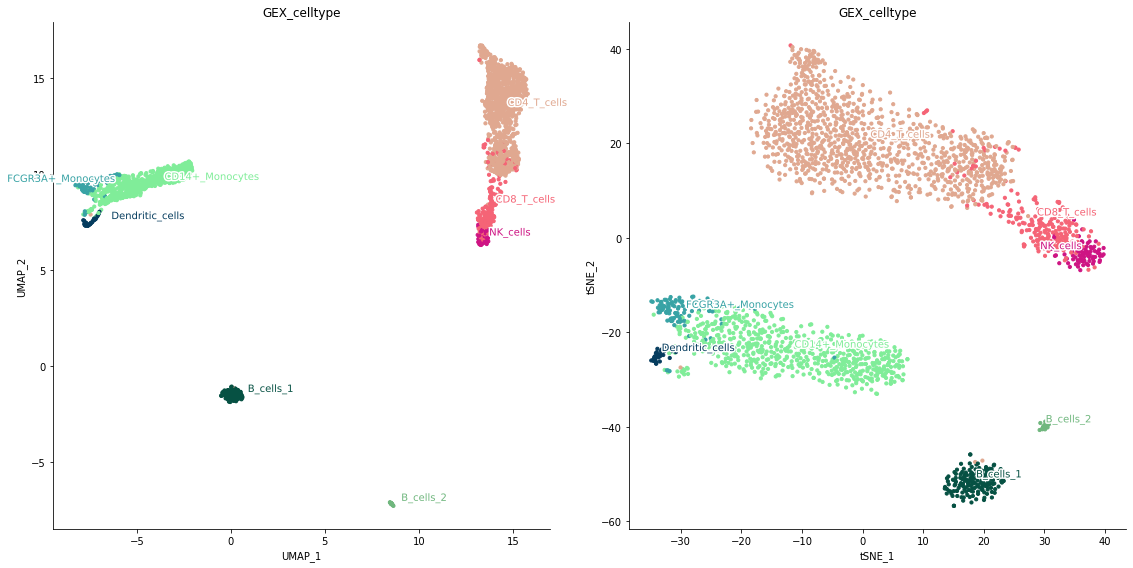

In [10]:
from scenicplus.dimensionality_reduction import plot_metadata_given_ax
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#specify color_dictionary

color_dict = {
    'B_cells_1': "#065143",
    'B_cells_2': "#70B77E",
    'CD4_T_cells': "#E0A890",
    'CD8_T_cells': "#F56476",
    'NK_cells': "#CE1483",
    'Dendritic_cells': "#053C5E" ,
    'FCGR3A+_Monocytes': "#38A3A5",
    'CD14+_Monocytes': "#80ED99"
}

fig, axs = plt.subplots(ncols=2, figsize = (16, 8))
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[0],
    reduction_name = 'eRegulons_UMAP',
    variable = 'GEX_celltype', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    color_dictionary={'GEX_celltype': color_dict}
)
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[1],
    reduction_name = 'eRegulons_tSNE',
    variable = 'GEX_celltype', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    color_dictionary={'GEX_celltype': color_dict}
)
fig.tight_layout()
sns.despine(ax = axs[0]) #remove top and right edge of axis border
sns.despine(ax = axs[1]) #remove top and right edge of axis border
plt.show()

### plot the activity / expression of an eRegulon on the dimensionality reduction

Nex we visualize the gene expression and target gene and region activity of some eRegulons on the tSNE.

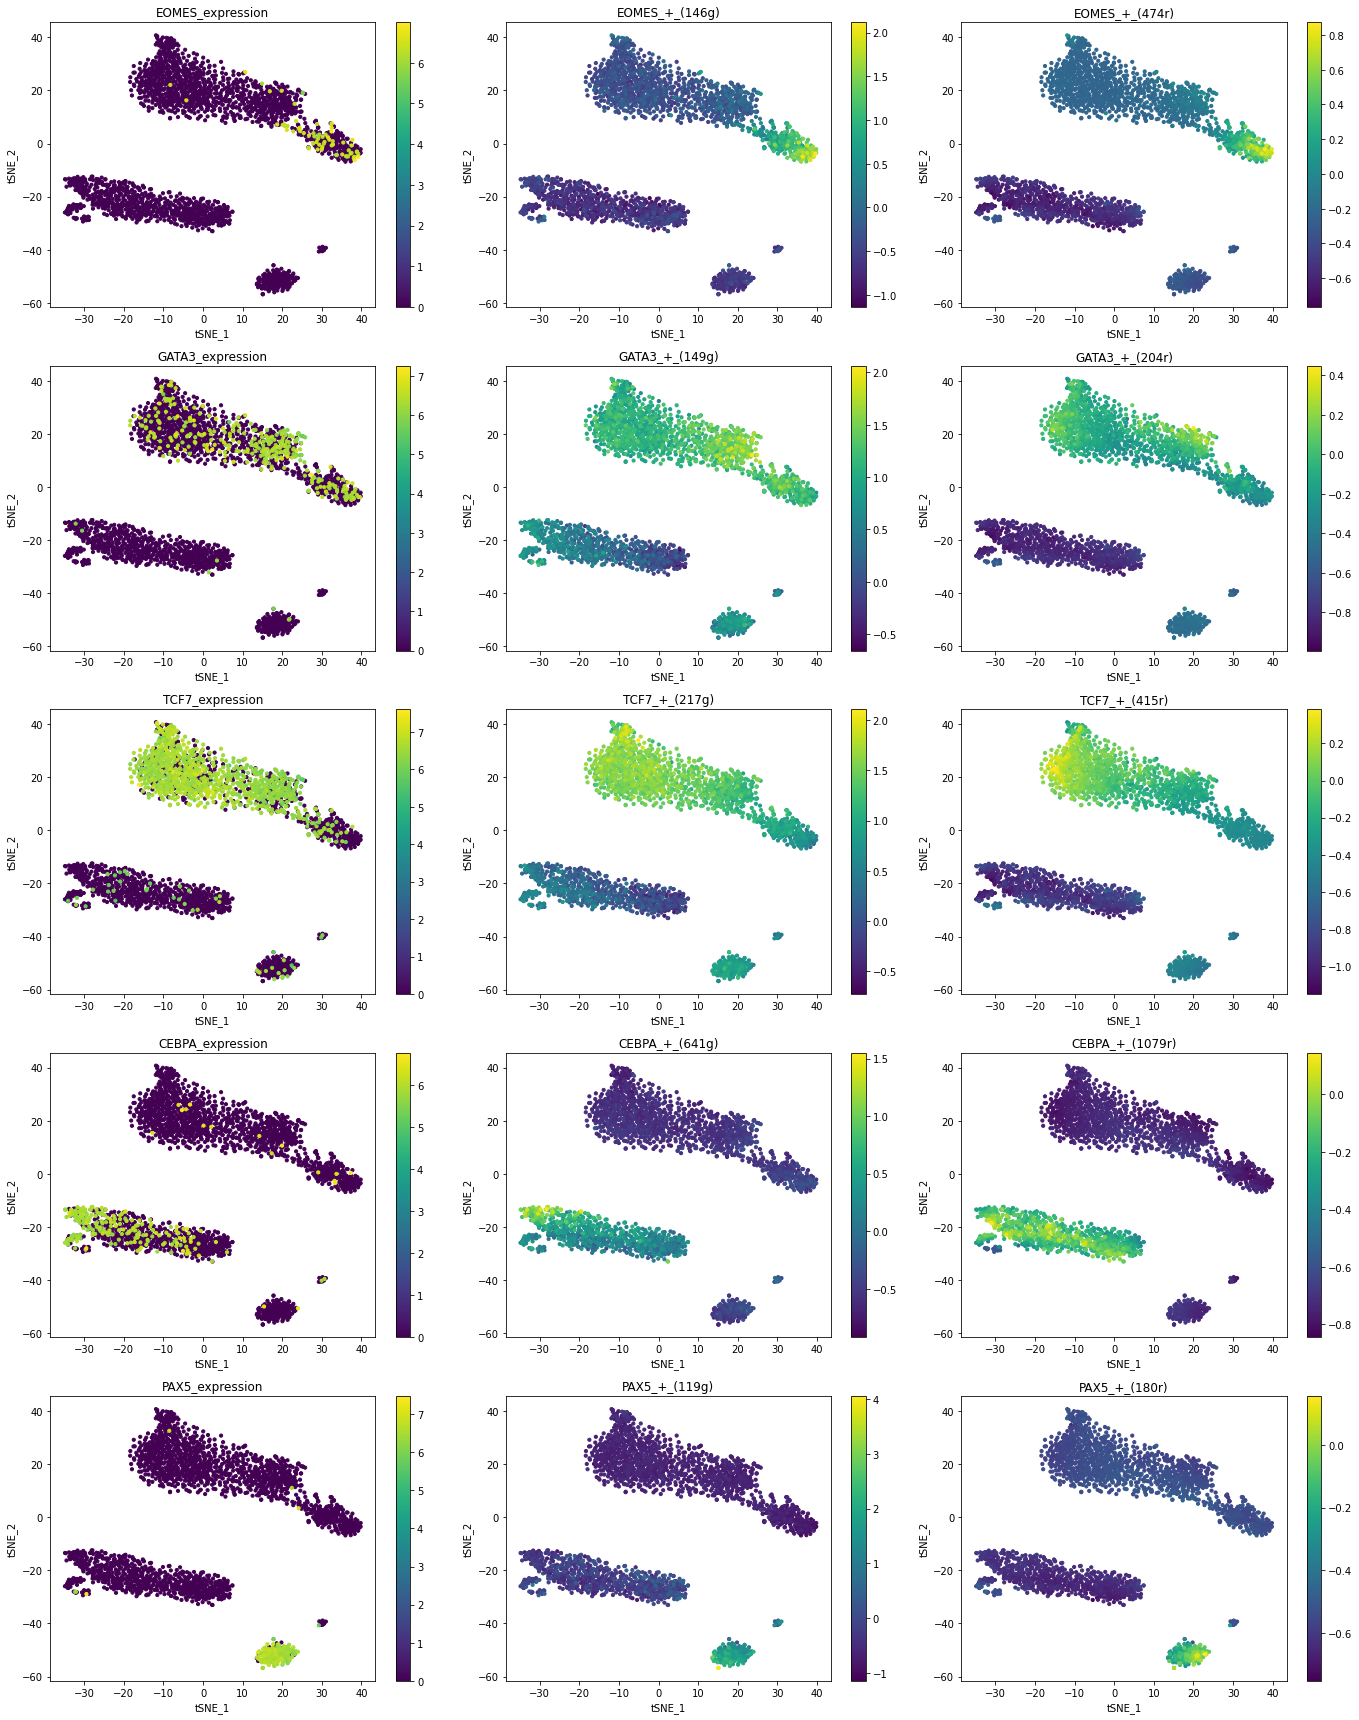

In [101]:
from scenicplus.dimensionality_reduction import plot_eRegulon
plot_eRegulon(
    scplus_obj = scplus_obj,
    reduction_name = 'eRegulons_tSNE',
    selected_regulons = ['EOMES_+', 'GATA3_+', 'TCF7_+', 'CEBPA_+', 'PAX5_+'],
    scale = True,
    auc_key = 'eRegulon_AUC_filtered')

We can also plot only the activity of an eRegulon

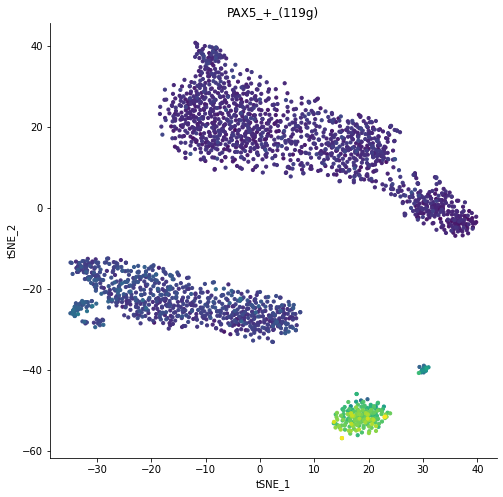

In [104]:
from scenicplus.dimensionality_reduction import plot_AUC_given_ax

fig, ax = plt.subplots(figsize = (8,8))
plot_AUC_given_ax(
    scplus_obj = scplus_obj,
    reduction_name = 'eRegulons_tSNE',
    feature = 'PAX5_+_(119g)',
    ax = ax,
    auc_key = 'eRegulon_AUC_filtered',
    signature_key = 'Gene_based')
sns.despine(ax = ax)
plt.show()

### dotplot-heatmap

For eRegulons it is often usefull to visualize both information on the TF/target genes expression and region accessibility at the same time.

A dotplot-heatmap is a useful way to visualize this. Here the color of the heatmap can be used to visualize one aspect of the eRegulon (for example TF expression) and the size of the dot can be used to visualize another aspect (for example the enrichment (AUC value) of eRegulon target regions).

Before we plot the the dotplot-heatmap let's first select some high quality eRegulons to limit the amount of space we need for the plot. One metric which can be used for selecting eRegulons is the correlation between TF expression and target region enrichment scores (AUC values). Let's (re)calculate this value based on the simplified eRegulons

We first generate pseudobulk gene expression and region accessibility data, per celltype, to limit the amount of noise for the correlation calculation.

In [15]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'GEX_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'GEX_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

In [24]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].head()

,TF,Cistrome,Rho,P-value,Adjusted_p-value
0,MXD1,MXD1_-_(10r),-0.448720,6.872141e-41,1.583580e-40
1,RREB1,RREB1_-_(91r),-0.700170,6.991867e-119,3.407531e-118
2,SREBF2,SREBF2_+_(191r),0.252339,4.369639e-13,6.939052e-13
3,ELF3,ELF3_+_(217r),0.107363,2.360010e-03,2.834687e-03
4,KLF8,KLF8_+_(324r),0.005392,8.789742e-01,8.894632e-01


Let's visualize these correlations in a scatter plot and select eRegulons for which the correlaiton coefficient is above 0.70 or below -0.75

/local_scratch/tmp-vsc33053/ipykernel_31660/1907631034.py:12: RuntimeWarning: divide by zero encountered in log10


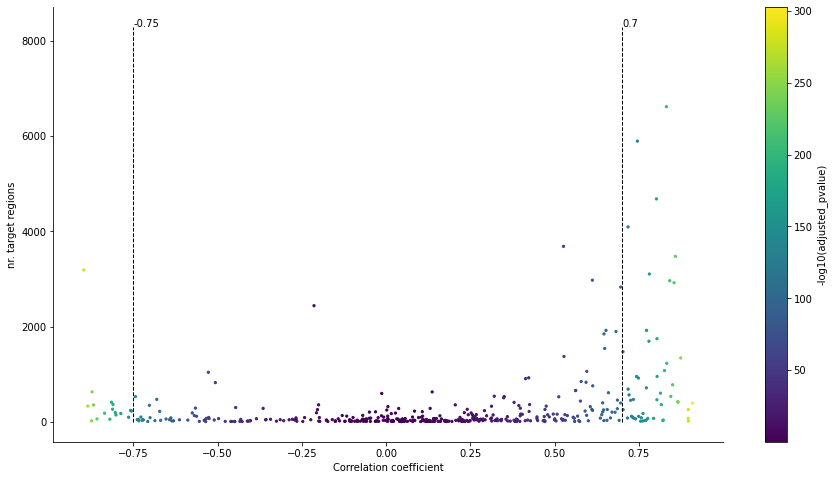

In [41]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.75, 0.70],
        'n_targets': 0
}
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [44]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 76 eRegulons


Let's save these changes we have made to the scenicplus_obj

In [68]:
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)

Let's plot the heatmap-dotplot

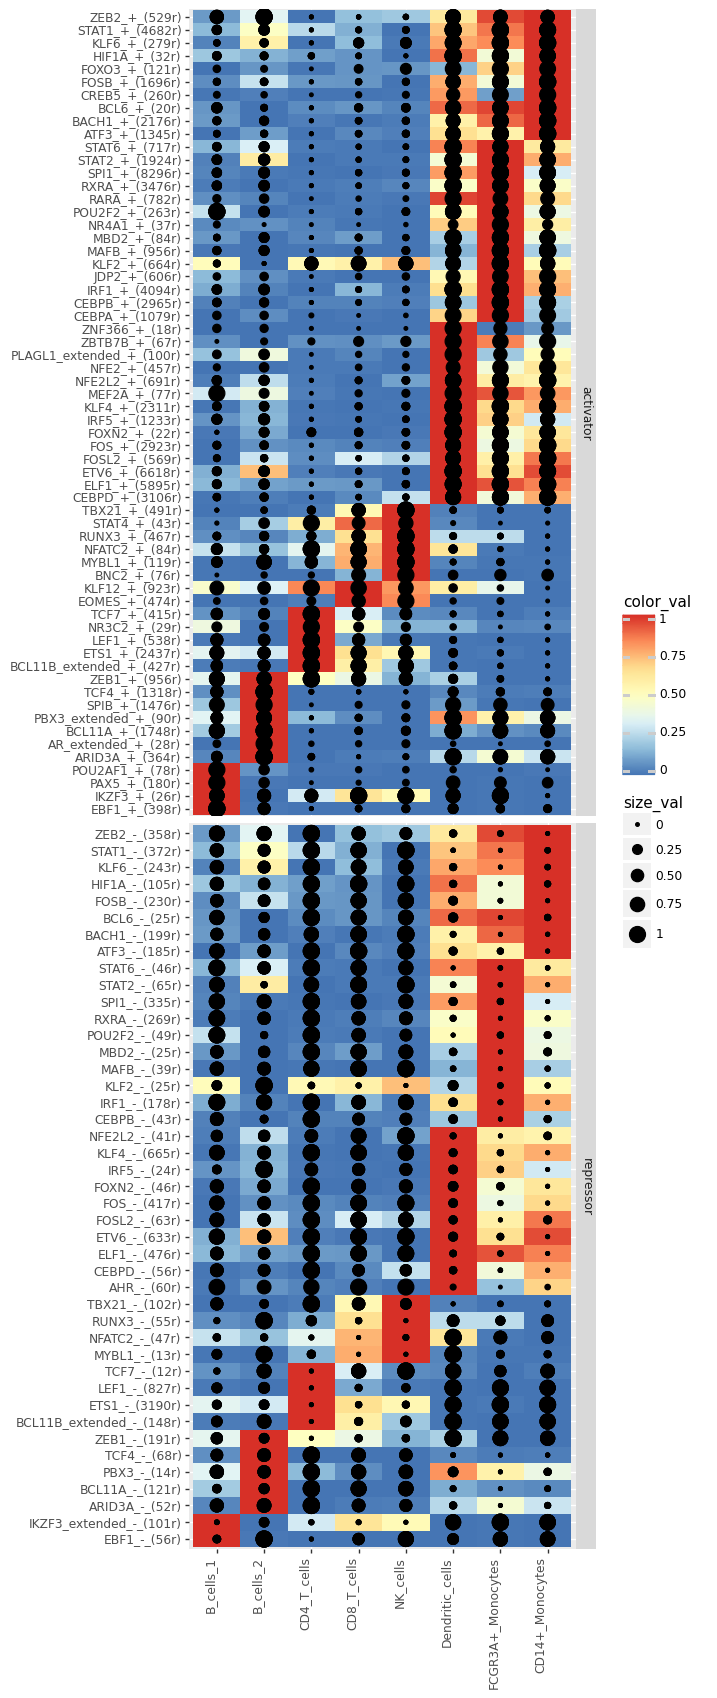

<ggplot: (2961768578286)>

In [48]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'GEX_celltype',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
        index_order = ['B_cells_1', 'B_cells_2', 'CD4_T_cells', 'CD8_T_cells', 'NK_cells', 'Dendritic_cells', 'FCGR3A+_Monocytes', 'CD14+_Monocytes'],
        figsize = (5, 20),
        orientation = 'vertical')

### overlap of predicted target regions
An interesting aspect of gene regulation is transcription factor cooperativity (i.e. multiple TFs cobinding the same enhancer together driving gene expression). 

By looking at the overlap of predicted target regions of TFs we can infer potential cooperativity events.

Let's look at the overlap of target regions of the top 5 TFs per cell type based on the Regulon Specificity Score (RSS). 

First we calculate the RSS for the target regions of the selected eRegulons.

In [51]:
from scenicplus.RSS import *
regulon_specificity_scores(
        scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_keys = ['Region_based'],
        selected_regulons = [x for x in scplus_obj.uns['selected_eRegulon']['Region_based'] if '-' not in x],
        out_key_suffix = '_filtered')

Let's visualize the RSS values using a scatter plot

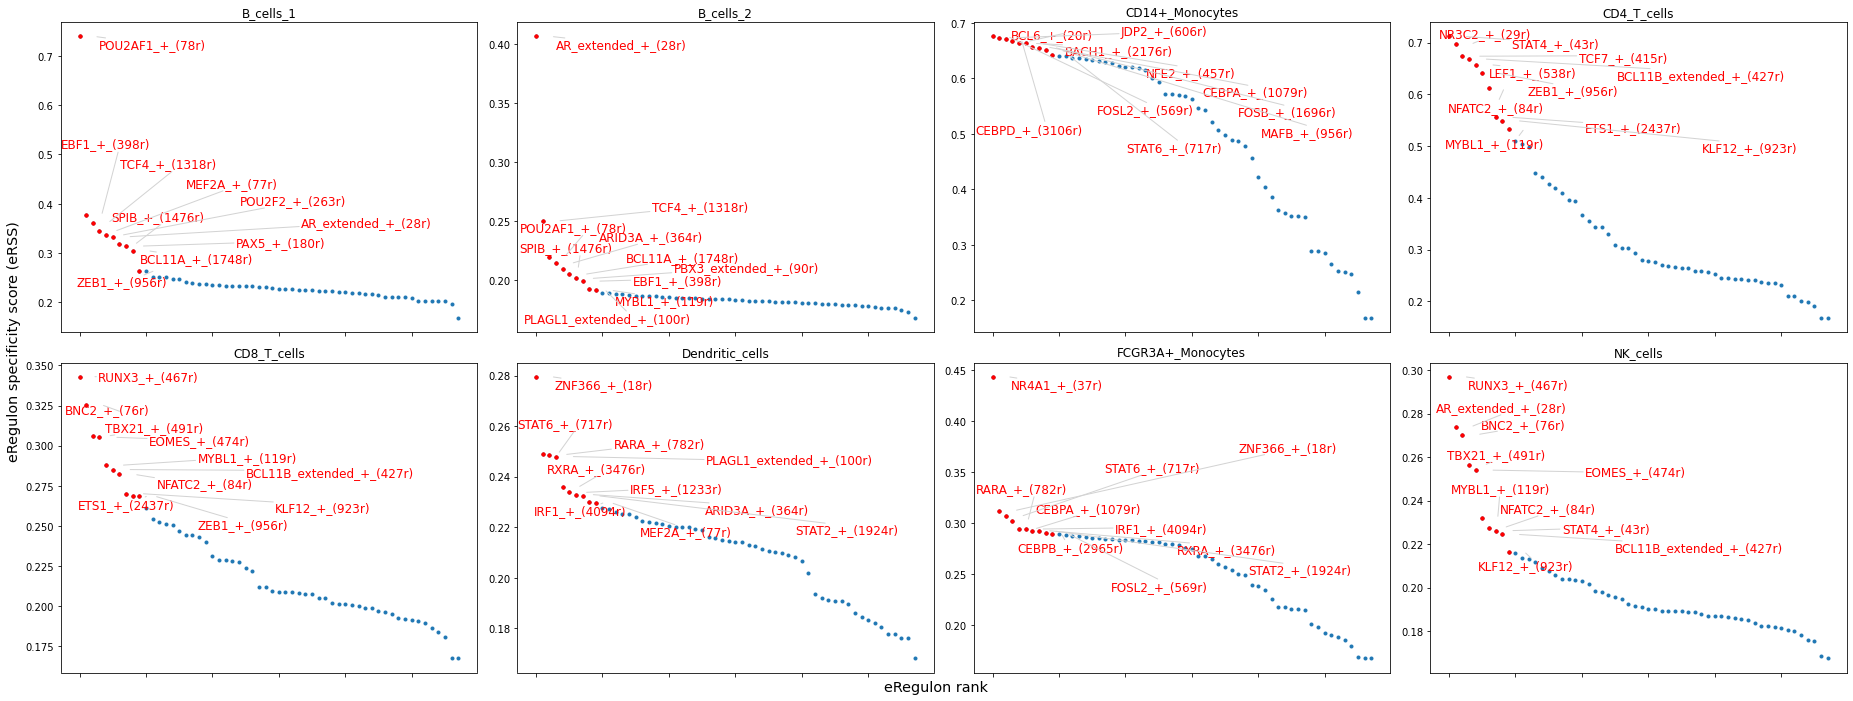

In [109]:
plot_rss(scplus_obj, 'GEX_celltype_filtered', num_columns=2, top_n=10, figsize = (5, 10))

Next we select the top 10 eRegulons per cell type

In [65]:
flat_list = lambda t: [item for sublist in t for item in sublist]
selected_markers = list(set(flat_list(
    [scplus_obj.uns['RSS']['GEX_celltype_filtered'].loc[celltype].sort_values(ascending = False).head(10).index.to_list() 
    for celltype in scplus_obj.uns['RSS']['GEX_celltype_filtered'].index])))

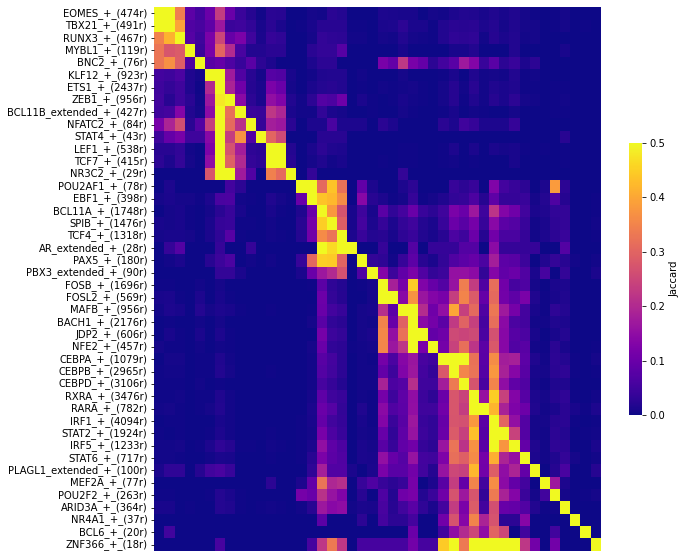

In [67]:
from scenicplus.plotting.correlation_plot import *

region_intersetc_data, Z = jaccard_heatmap(
        scplus_obj,
        method = 'intersect',
        gene_or_region_based = 'Region_based',
        use_plotly = False,
        selected_regulons = selected_markers,
        signature_key = 'eRegulon_signatures_filtered',
        figsize = (10, 10), return_data = True, vmax = 0.5, cmap = 'plasma')

### Plotting a network

eRegulons can also be visualized in a network. Simple plots can be made using python. For more complicated plots (i.e. containing many nodes and edges) we suggest exporting your network to cytoscape.

Let's create a very simple network for B cells. We will use the top 1000 highly variable regions and genes in this plot. If you want to use more feautures please export your nework to cytoscape.

In [91]:
from pycisTopic.diff_features import find_highly_variable_features
hvr = find_highly_variable_features(scplus_obj.to_df('ACC').loc[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Region']))], n_top_features=1000, plot = False)
hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Gene']))].T, n_top_features=1000, plot = False)

2022-08-08 17:02:54,730 cisTopic     INFO     Calculating mean
2022-08-08 17:02:54,783 cisTopic     INFO     Calculating variance
2022-08-08 17:02:56,192 cisTopic     INFO     Done!
2022-08-08 17:02:56,327 cisTopic     INFO     Calculating mean
2022-08-08 17:02:56,340 cisTopic     INFO     Calculating variance
2022-08-08 17:02:56,503 cisTopic     INFO     Done!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

First we format the eRegulons into a table which can be used to create a network using the package [networkx](https://networkx.org/)

In [92]:
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
nx_tables = create_nx_tables(
    scplus_obj = scplus_obj,
    eRegulon_metadata_key ='eRegulon_metadata_filtered',
    subset_eRegulons = ['PAX5', 'EBF1', 'POU2AF1'],
    subset_regions = hvr,
    subset_genes = hvg,
    add_differential_gene_expression = True,
    add_differential_region_accessibility = True,
    differential_variable = ['GEX_celltype'])

/user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/user/leuven/330/vsc33053/sdewin/Programs/anaconda3/envs/scenicplus/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


Next we layout the graph.

In [93]:
G, pos, edge_tables, node_tables = create_nx_graph(nx_tables, 
                   use_edge_tables = ['TF2R','R2G'],
                   color_edge_by = {'TF2R': {'variable' : 'TF', 'category_color' : {'PAX5': 'Orange', 'EBF1': 'Purple', 'POU2AF1': 'Red'}},
                                    'R2G': {'variable' : 'R2G_rho', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'R2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'R2G': {'variable' : 'R2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {'TF': {'variable': 'TF', 'category_color' : {'PAX5': 'Orange', 'EBF1': 'Purple', 'POU2AF1': 'Red'}},
                                    'Gene': {'variable': 'GEX_celltype_Log2FC_B_cells_1', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'GEX_celltype_Log2FC_B_cells_1', 'continuous_color' : 'viridis'}},
                   transparency_node_by =  {'Region': {'variable' : 'GEX_celltype_Log2FC_B_cells_1', 'min_alpha': 0.1},
                                    'Gene': {'variable' : 'GEX_celltype_Log2FC_B_cells_1', 'min_alpha': 0.1}},
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 15},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 10}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='kamada_kawai_layout',
                   scale_position_by=250)

Finally we can visualize the network.

In this network diamond shapes represent regions and they are color coded by their log2fc value in B cells target genes and TFs are visualized using circles and are labeled.

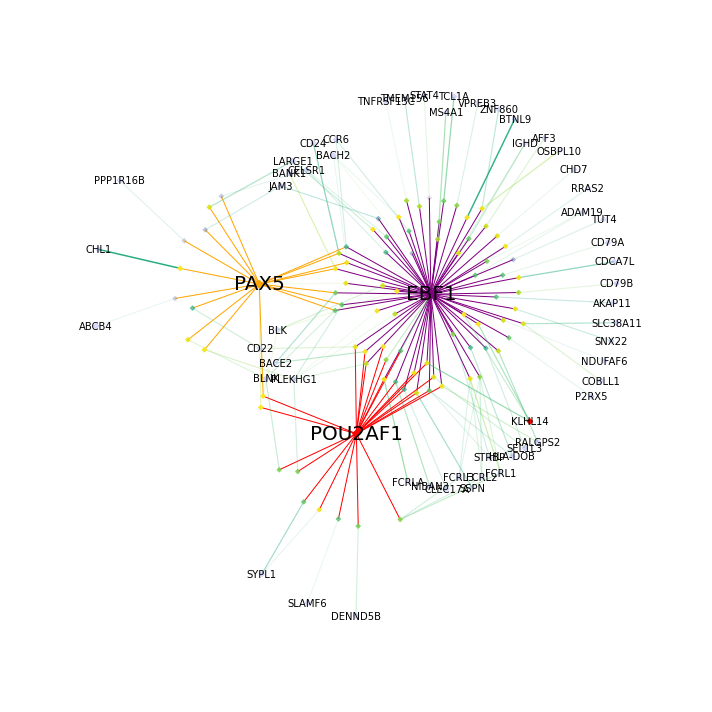

In [94]:
plt.figure(figsize=(10,10))
plot_networkx(G, pos)

We can also export this network to a format which can be opened in Cytoscape.

In [110]:
export_to_cytoscape(G, pos, out_file = os.path.join(work_dir, 'scenicplus/network_B_cells.cys'))

This network can be imported using `file -> import -> Network from file ...`

Also make sure to import the SCENIC+ network layout using `file -> import -> Styles from file ...`.

This layout is available under [cytoscape_styles/SCENIC+.xml](https://raw.githubusercontent.com/aertslab/scenicplus/main/cytoscape_styles/SCENIC%2B.xml).

## Conclusion

This concludes the SCENIC+ tutorial on PBMCs.

In this tutorial we started from a fragments file and a gene expression matrix, which are publicly available on the 10x website. 

Based on the gene expression side of the data we annotated cell types and used these annotations for generating pseudobulk ATAC-seq profiles on which we called consensus peask.

This consensus peaks set was used as features for running pycisTopic with which we looked for enhancer candidates and using pycistarget we found which motifs were enriched in these candidates.

Finally, we combined all these results in order to run SCENIC+ for which we did some downstream exploration.

Below is an overview of all the files generated in this tutorial.

In [2]:
!tree pbmc_tutorial/

pbmc_tutorial/
|-- bedToBigBed
|-- data
|   |-- pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz
|   |-- pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5
|   `-- utoronto_human_tfs_v_1.01.txt
|-- motifs
|   |-- CTX_DARs_All
|   |   |-- B_cells_1.html
|   |   |-- B_cells_2.html
|   |   |-- CD14+_Monocytes.html
|   |   |-- CD4_T_cells.html
|   |   |-- CD8_T_cells.html
|   |   |-- Dendritic_cells.html
|   |   |-- FCGR3A+_Monocytes.html
|   |   `-- NK_cells.html
|   |-- CTX_DARs_No_promoters
|   |   |-- B_cells_1.html
|   |   |-- B_cells_2.html
|   |   |-- CD14+_Monocytes.html
|   |   |-- CD4_T_cells.html
|   |   |-- CD8_T_cells.html
|   |   |-- Dendritic_cells.html
|   |   |-- FCGR3A+_Monocytes.html
|   |   `-- NK_cells.html
|   |-- CTX_topics_otsu_All
|   |   |-- Topic1.html
|   |   |-- Topic10.html
|   |   |-- Topic11.html
|   |   |-- Topic12.html
|   |   |-- Topic13.html
|   |   |-- Topic14.html
|   |   |-- Topic15.html
|   |   |-- Topic16.html
|   |   |-- Topic2.html
|   |   |

The files in the folder `scATAC/consensus_peak_calling/pseudobulk_bw_files/*` and `scATAC/consensus_peak_calling/MACS/*.narrowPeak` are very useful for visualising cell type specific region accessibility in IGV or the UCSC genomebrowser. You can combine this (only in the UCSC genome browser) with `scenicplus/eRegulons.bb`, `scenicplus/r2g.importance.bb` and/or `scenicplus/r2g.rho.bb` to get a more complete view including region to gene links and predicted eRegulon bindin sites.

The files `scenicplus/SCENIC+_gene_based.loom` and `scenicplus/SCENIC+_region_based.loom` can be visualized in SCope.

The file: `scenicplus/network_B_cells.cys` can be visualised in Cytoscape.